# ☀ Analysis of Brisbane Photovoltaic Installation Data ☀


## Introduction

For this excerise I will take open data on demographic profiles of various suburbs around Brisbane to answer four questions relating to a problem statement. 
The problem statement is:
> Our customer wishes to use this data to understand possible demand for solar panel installations when entering a new region, where counts of installations will not be available but the other factors will be present. This will allow them to focus advertising on suburbs where they are most likely to have a high demand.

The questions are:
1. Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.
2. Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.
3. Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.
4. Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

I will include a preamble to each question that tries to explain my approach and then I will follow it with analysis and finally by a conclusion and answer.

---

## Import packages and data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re

In [2]:
# Read in data file to dataframe
df = pd.read_excel('Brisbane Suburbs Stats Separated V2.0.xlsx')

---

## Question 1

> Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.

My first thoughts are to understand and categorise the columns in the dataframe.

Relating this back to the problem statement, we should try to reconcile these against different levers that may have an affect on demand for solar panel installations. 

Below are some thoughts for factors that might contribute off the top of my head.
* Economic levers:
    - Financial position of residents
        - Renters
        - Mortgage/owned
        - Employment
            - Salary
    - Construction and real estate
        - New builds
        - Renovations
        - Sales
        - Subsidies? (i.e. are there incentives to build solar panels when building/renovating?)
            - Do these subsidies apply outside of Brisbane/QLD?
    - Electricity usage
    - Proximity to supplier
        - Is this confounded by geography?
* Geographical levers:
    - Weather
    - Altitude
    - Proximity to supplier
* Demographic levers:
    - Do particular demographies have higher demand?
    - Do changing demographies drive demand?
    - Can election results in suburb predict demand for solar? (e.g. do Green's voters install more solar panels?)
    - Penetration in suburb/neighbouring suburb (i.e. does a rising number of solar panels make others consider installation?)
    - Industry of residents
    - Population density

Limitations:
* We might be missing some relationships because of the spread of data in different years


Methods for finding these factors?

List some ideas here when I have them to keep track....

Correlation


---

In [3]:
# Derive some extra columns

# Some extra time series data
# I'm doing this first and in different for loops to make sure the time series stuff all appears in one group and in order of category
for year in range(2002, 2019):
    df[f'Avg new house value {year}'] = df[f'BA Value of new houses {year}']/df[f'BA New houses {year}']
for year in range(2002, 2019):
    df[f'Avg alts & adds {year}'] = (df[f'BA Value of alts & adds to residential building {year}']/df[f'BA Total dwellings {year}'])

# Some other columns that will be helpful
df['Total Population (2017)'] = df[df.columns[5:23]].sum(axis=1)  # I've assumed the age columns capture everyone living in a given suburb
df['Approx km2'] = df['Total Population (2017)']/df['Population density (ERP at 30 June) (persons/km2) 2018']  # Here I've assumed the population has not changed much between 2017 and 2018
df['Solar installations per capita (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['Total Population (2017)']
df['Solar installations per dwelling (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['BA Total dwellings 2017']
df['Solar installations per new house (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['BA New houses 2017']
df['Solar installations per new house value (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['BA Value of new houses 2017']
df['Solar installations per alts & adds value (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['BA Value of alts & adds to residential building 2017']

# Replace infinite values with NaNs so that they don't mess up averages, etc
df.replace([np.inf, -np.inf], np.nan,inplace=True)

In [4]:
# Isolate index and target columns
idx_col           = df.columns[2:3]  # I don't think I need Suburb or Postcode - Just use ABS code as index
target_col        = df.columns[101:102]

# Categorise the columns into different groups
dist_cols         = df.columns[3:5]
age_cols          = df.columns[5:23]
pop_cols          = df.columns[23:24].union(['Total Population (2017)', 'Approx km2'])
ethnicity_cols    = df.columns[24:38]
construction_cols = df.columns[38:42].union(df.columns[113:266])
industry_cols     = df.columns[42:61]    # Rental is included in here?
finance_cols      = df.columns[61:94].union(df.columns[105:113])   # Note: mixture of 2016 and 2018 data in here
housing_cols      = df.columns[94:101]
solar_cols        = df.columns[101:105].union(df.columns[268:])  # NOTE: Includes target column

In [5]:
df[solar_cols.union(['Suburb'])]

Increase in SWH installations from previous year (%) 2017  \
0                                                  5.2           
1                                                  4.5           
2                                                  2.9           
3                                                  4.3           
4                                                  3.2           
..                                                 ...           
259                                                4.3           
260                                                3.9           
261                                                4.0           
262                                                4.2           
263                                                3.3           

     Increase in installations from previous year (%) 2017  \
0                                                  8.7       
1                                                  8.0       
2                                                 10.2       
3                                                  5.5       
4                                                  5.4       
..                                                 ...       
259                                                9.7       
260                                                7.7       
261                                                7.4       
262                                               12.2       
263                                                6.3       

     Small-scale solar panel system installations (no.) 2017  \
0                                                 2513         
1                                                  148         
2                                                  420         
3                                                 2571         
4                                                 1287         
..                                                 ...         
259                                               1110         
260                                               1481         
261                                               1752         
262                                                643         
263                                                905         

     Solar installations per alts & adds value (2017)  \
0                                            0.825775   
1                                            0.051882   
2                                            0.045768   
3                                            1.236295   
4                                            1.768343   
..                                                ...   
259                                          0.201895   
260                                          0.236430   
261                                          0.478479   
262                                          0.104492   
263                                          1.076356   

     Solar installations per capita (2017)  \
0                                 0.153241   
1                                 0.046236   
2                                 0.065339   
3                                 0.152049   
4                                 0.144835   
..                                     ...   
259                               0.134545   
260                               0.105839   
261                               0.113149   
262                               0.062953   
263                               0.095243   

     Solar installations per dwelling (2017)  \
0                                  38.075758   
1                                   7.047619   
2                                   7.924528   
3                                  64.275000   
4                                  27.382979   
..                                       ...   
259                                34.687500   
260                                15.112245   
261                         

In [6]:
# Create time series with BA data
start = 113
yrs = 17
re_pattern = r'(.*) (\d{4})'

df_time = None

for i in range(9):
    melt_vars = df.columns[start:start+yrs]
    start += yrs  # increment for next iteration
    name = re.search(re_pattern, melt_vars[0])[1]
    col_rename = {
        col: int(re.search(re_pattern, col)[2]) for col in melt_vars
    }
    
    if df_time is None:
        df_time = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        )

    else:
        temp = pd.melt(
            df[idx_col.union(melt_vars)].rename(columns=col_rename),
            id_vars=idx_col,
            var_name='Year',
            value_name=name
        ).set_index(['ABS Code', 'Year'])
        
        df_time = df_time.join(
            temp, 
            on=['ABS Code', 'Year'], 
            how='left'
        )
        
# Add in mean, Q1, median, Q3 for plotting/comparison
df_time_agg = None
agg_label = 'Agg'

# Mean
df_time_agg = df_time.drop(columns=idx_col).groupby('Year').mean().reset_index()
df_time_agg[agg_label] = 'Mean'

# Q1, Median, Q3
temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.25).reset_index()
temp[agg_label] = 'Q1'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.5).reset_index()
temp[agg_label] = 'Median'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

temp = df_time.drop(columns=idx_col).groupby('Year').quantile(0.75).reset_index()
temp[agg_label] = 'Q3'
df_time_agg = pd.concat(
    [df_time_agg, temp]
)

The cell below is just for testing

In [7]:
# Test to see I captured all columns
all_cols = idx_col.union(target_col)\
    .union(dist_cols).union(age_cols).union(pop_cols).union(ethnicity_cols)\
    .union(construction_cols).union(industry_cols).union(finance_cols).union(housing_cols).union(solar_cols)

# This helps me 
# list(enumerate(df.columns))[:]

# Check I have all columns present and accounted for (I'm ok leaving out Suburb and Postcode)
[(i, col) for i, col in enumerate(df.columns) if col not in all_cols]

[(0, 'Suburb'), (1, 'Postcode ')]

### Find correlation using Pearson and Spearman's correlation

This is a good way to get started since the correlation coefficients are invariant to normalisation.

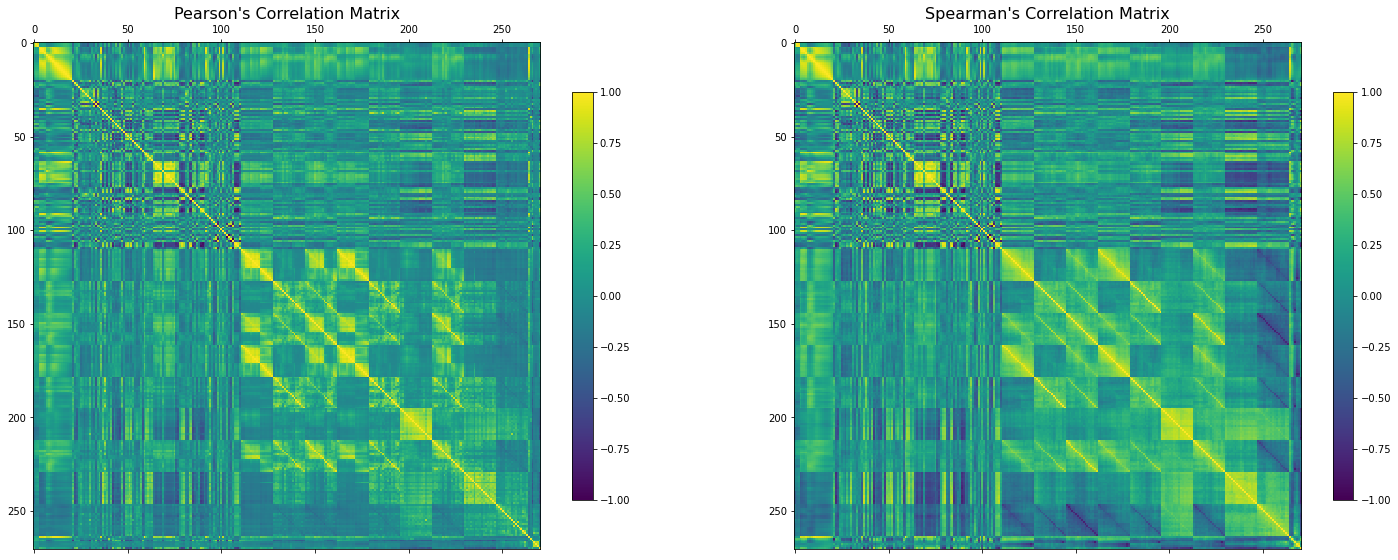

In [8]:
correlation_mat = df.corr(method='pearson')
spearman_mat = df.corr(method='spearman')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.matshow(correlation_mat, fignum=False)
plt.title("Pearson's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()

plt.subplot(1, 2, 2)
plt.matshow(spearman_mat, fignum=False)
plt.title("Spearman's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()
plt.show()

There's a lot going on here due to the sheer number of columns, but we can definitely see plenty of dark blue and yellow indicating there is correlation to be found. The blocks in the bottom right are from the time series data which makes sense that they are correlated. Let's take a look at the distribution of these correlation coefficients to see how strong some of them are.

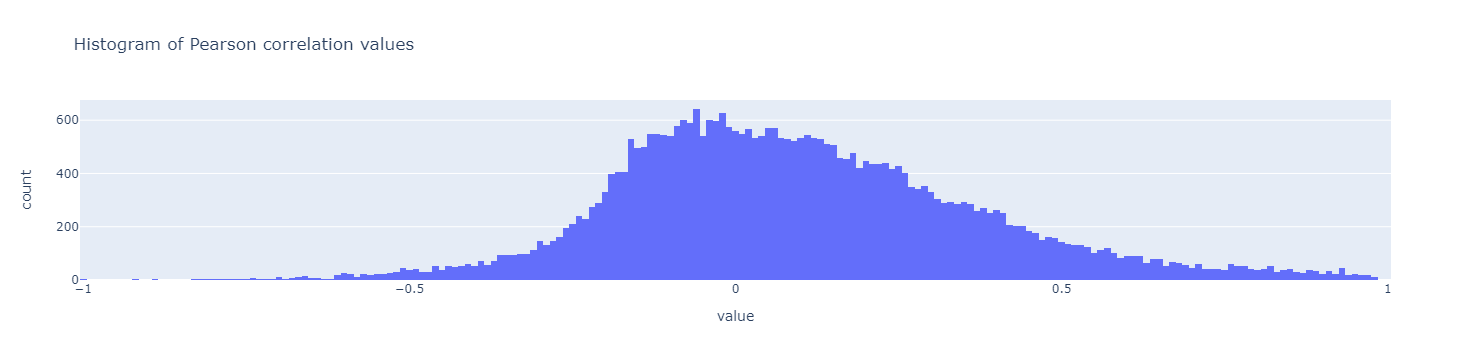

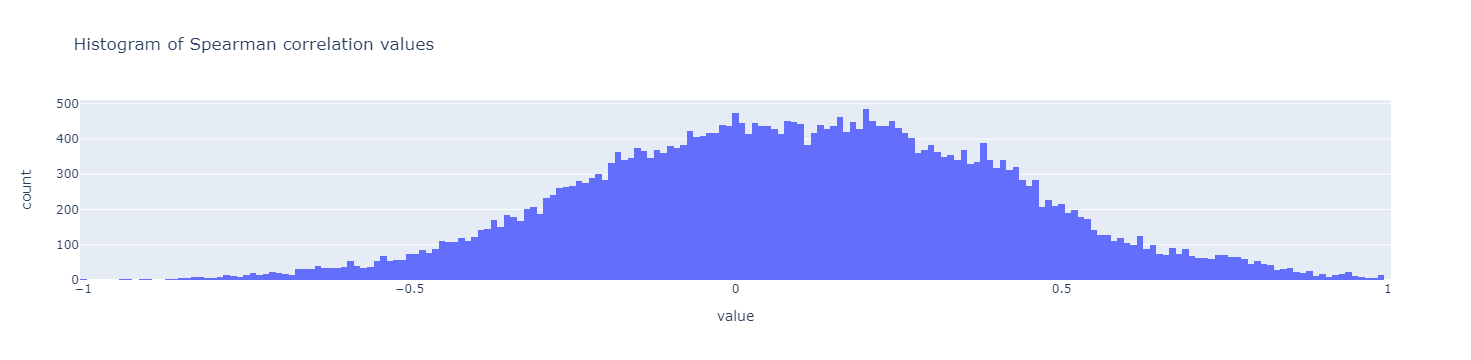

Number of pairs with Pearson correlation in [-1.00, -0.80): 22        Number of pairs with Spearman correlation in [-1.00, -0.80): 63
Number of pairs with Pearson correlation in [-0.80, -0.60): 146       Number of pairs with Spearman correlation in [-0.80, -0.60): 439
Number of pairs with Pearson correlation in [-0.60, -0.40): 705       Number of pairs with Spearman correlation in [-0.60, -0.40): 1486
Number of pairs with Pearson correlation in [-0.40, -0.20): 2977      Number of pairs with Spearman correlation in [-0.40, -0.20): 4353
Number of pairs with Pearson correlation in [-0.20, 0.00): 10751      Number of pairs with Spearman correlation in [-0.20, 0.00): 7659
Number of pairs with Pearson correlation in [0.00, 0.20): 10367       Number of pairs with Spearman correlation in [0.00, 0.20): 8682
Number of pairs with Pearson correlation in [0.20, 0.40): 6827        Number of pairs with Spearman correlation in [0.20, 0.40): 7721
Number of pairs with Pearson correlation in [0.40, 0.60)

In [9]:
# Flatten correlation matrix
# Note: only need to count up to the ith element in each row since matrix is symmetric with 1s along the 
#       diagonal which we can exclude (as they offer no insight)
corr_vals = [item for i, row in enumerate(correlation_mat.values.tolist()) for item in row[:i]]
spearman_vals = [item for i, row in enumerate(spearman_mat.values.tolist()) for item in row[:i]]

# Histogram of correlation values to determine what the correlation looks like
# This could be better as a density but I find it more informative as a count
fig = px.histogram(
    corr_vals,
    title='Histogram of Pearson correlation values'
)

fig.update_layout(showlegend=False)
fig.show()

fig = px.histogram(
    spearman_vals,
    title='Histogram of Spearman correlation values',
)

fig.update_layout(showlegend=False)
fig.show()

# This can probably go but I was just interested in seeing the counts
n = 10
for i in range(n):
    lower, upper = 2*i/n - 1, 2*(i+1)/n - 1
    # Print number of pairs in different correlation bands for extra context
    print(
        f"Number of pairs with Pearson correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in corr_vals if lower <= v < upper])}".ljust(70) +\
        f"Number of pairs with Spearman correlation in [{lower:0.2f}, {upper:0.2f}): {len([v for v in spearman_vals if lower <= v < upper])}"
    )

print("-"*140)
    
# Just to make sure there are none perfectly correlated
print(
    f"Number of pairs with Pearson correlation == {-1:0.2f}: {len([v for v in corr_vals if v == -1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {-1:0.2f}: {len([v for v in spearman_vals if v == -1])}"
)

print(
    f"Number of pairs with Pearson correlation == {1:0.2f}: {len([v for v in corr_vals if v == 1])}".ljust(70) +\
    f"Number of pairs with Spearman correlation == {1:0.2f}: {len([v for v in spearman_vals if v == 1])}"
)

Interesting to see that there are two pairs with a Spearman correlation of -1; let's investigate!

In [11]:
# Get block of matrix with any -1 in them
spearman_mat[b := (spearman_mat == -1).any()][spearman_mat[b].index.values]

Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                           1.000000                                     
Households with mortgage repayments greater tha...                                          -1.000000                                     
Households where rent payments are less than 30...                                          -0.535715                                     
Households with rent payments greater than or e...                                           0.535715                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                          -1.000000                                               
Households with mortgage repayments greater tha...                                           1.000000                                               
Households where rent payments are less than 30...                                           0.535715                                               
Households with rent payments greater than or e...                                          -0.535715                                               

                                                    Households where rent payments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                          -0.535715                               
Households with mortgage repayments greater tha...                                           0.535715                               
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                           0.535715                                        
Households with mortgage repayments greater tha...                                          -0.535715                                        
Households where rent payments are less than 30...                                          -1.000000                                        
Households with rent payments greater than or e...                                           1.000000

It makes total sense that these are inversely proportional. The Spearman correlation has identified that for each pair of variables (v1, v2) with correlation == -1, v1 = 1-v2.

They're clearly dependent, so we should remove one of these columns from each pair if we want to do regression.

Let's examine some more of the correlations closer to -1 and 1.

In [12]:
# I'm going to make a little lambda function to speed this up
# Note: Pandas is inelegant for checking for diagonals, so we check that it's not a trivial
#       correlation in corr_matrices_between before adding it to blocks
corr_between = lambda d, gt, leq: d[(b := ((gt < d) & (d <= leq)).any())][d[b].index.values]


def corr_matrices_between(d, gt, leq, absolute=False):
    """
    This takes a correlation matrix d and finds blocks of correlation with 
    coefficients greater than gt and less than or equal to leq.
    
    Set absolute=True if you want to consider both strong positive and negative correlation.
    
    Note: Pandas is inelegant for checking for diagonals, so we check that it's not a trivial
          correlation before adding it to blocks
    """
    # Iterate over variables that have a correlation coefficient between gt and leq
    def recurse(varlist, d=d, gt=gt, leq=leq, absolute=absolute):
        if absolute:
            s = ((gt < abs(d.loc[varlist])) & (abs(d.loc[varlist]) <= leq)).any()
        else:
            s = ((gt < d.loc[varlist]) & (d.loc[varlist] <= leq)).any()
        new = s[s].index
        
        if len(new.union(varlist)) == len(varlist):
            return varlist
        else:
            return recurse(new.union(varlist), d, gt, leq)
    
    blocks = []
    if absolute:
        all_indices = d[((gt < abs(d)) & (abs(d) <= leq)).any()].index
    else:
        all_indices = d[((gt < d) & (d <= leq)).any()].index
    
    used_vars = all_indices[0:0]
    
    # We don't want variables to appear again if they already appear in a block so
    # iterate over the relevant indices and check if they've appeared in used_vars.
    for i, var in enumerate(all_indices):
        if var not in used_vars:
            new_vars = recurse(all_indices[i:i+1], d, gt, leq, absolute)
            if len(new_vars) > 1:
                blocks.append(d[new_vars].loc[new_vars])
            used_vars = used_vars.union(new_vars)
        else:
            pass
    
    return blocks

I'm now going to dump out a bunch of correlation matrices to look at

In [15]:
gt, leq = (-1.1, -0.9)
corr_mats = corr_matrices_between(spearman_mat, gt, leq)

# We can just sum the count of variables in each block because they're all MECE
print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 4 total blocks with dependencies between -1.1 and -0.9 that account for 16 variables
Dependency block 1:


Australian citizen (%) 2016  \
Australian citizen (%) 2016                            1.000000   
Not an Australian citizen (%) 2016                    -0.930939   

                                    Not an Australian citizen (%) 2016  
Australian citizen (%) 2016                                  -0.930939  
Not an Australian citizen (%) 2016                            1.000000

Dependency block 2:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
Machinery operators and drivers (%) 2016                      0.874418   
Persons over 15 earning $2000-$2999 per week (%...           -0.927794   
Persons over 15 earning $3000 or more per week ...           -0.911329   
Professional Scientific & Technical Services (%...           -0.874502   
Professionals (%) 2016                                       -0.868043   
SEIFA decile ranking - Index of Education and O...           -0.920349   
SEIFA decile ranking - Index of Relative Socio-...           -0.939870   
SEIFA decile ranking - Index of Relative Socio-...           -0.902990   

                                                    Machinery operators and drivers (%) 2016  \
Labourers (%) 2016                                                                  0.874418   
Machinery operators and drivers (%) 2016                                            1.000000   
Persons over 15 earning $2000-$2999 per week (%...                                 -0.822430   
Persons over 15 earning $3000 or more per week ...                                 -0.895178   
Professional Scientific & Technical Services (%...                                 -0.913648   
Professionals (%) 2016                                                             -0.914181   
SEIFA decile ranking - Index of Education and O...                                 -0.937694   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.850811   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.739244   

                                                    Persons over 15 earning $2000-$2999 per week (%) 2016  \
Labourers (%) 2016                                                                          -0.927794       
Machinery operators and drivers (%) 2016                                                    -0.822430       
Persons over 15 earning $2000-$2999 per week (%...                                           1.000000       
Persons over 15 earning $3000 or more per week ...                                           0.915522       
Professional Scientific & Technical Services (%...                                           0.877665       
Professionals (%) 2016                                                                       0.855389       
SEIFA decile ranking - Index of Education and O...                                           0.897999       
SEIFA decile ranking - Index of Relative Socio-...                                           0.940635       
SEIFA decile ranking - Index of Relative Socio-...                                           0.898475       

                                                    Persons over 15 earning $3000 or more per week (%) 2016  \
Labourers (%) 2016                                                                          -0.911329         
Machinery operators and drivers (%) 2016                                                    -0.895178         
Persons over 15 earning $2000-$2999 per week (%...                                           0.915522         
Persons over 15 earning $3000 or more per week ...                                           1.000000         
Professional Scientific & Technical Services (%...                                           0.881976         
Professionals (%) 2016                                                                       0.844251         
SEIFA decile ranking - Index of Education and O...                                           0.915433         
SEIFA decile ranking - Index of Relative Socio-...                                           0.923385         
SEIFA decile ranking - Index of Relative Socio-...                                           0.847151         

                                                    Professional Scientific & Technical Services (%) 2016  \
Labourers (%) 2016                     

Dependency block 3:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               
Rented (%) 2016                                                                             -0.937898                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                          -1.000000                                         
Households with rent payments greater than or e...                                           1.000000                                         
Rented (%) 2016                                                                              0.937898                                         

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.937898  
Households with rent payments greater than or e...         0.937898  
Rented (%) 2016                                            1.000000

Dependency block 4:


Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                                1.0                                     
Households with mortgage repayments greater tha...                                               -1.0                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                               -1.0                                              
Households with mortgage repayments greater tha...                                                1.0

In [16]:
gt, leq = (-1.1, -0.9)
corr_mats = corr_matrices_between(correlation_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 4 total blocks with dependencies between -1.1 and -0.9 that account for 10 variables
Dependency block 1:


Machinery operators and drivers (%) 2016  \
Machinery operators and drivers (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Education and O...                                 -0.922187   

                                                    SEIFA decile ranking - Index of Education and Occupation (IEO) 2016  
Machinery operators and drivers (%) 2016                                                    -0.922187                    
SEIFA decile ranking - Index of Education and O...                                           1.000000

Dependency block 2:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Relative Socio-...           -0.918736   
SEIFA decile ranking - Index of Relative Socio-...           -0.904158   

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) 2016  \
Labourers (%) 2016                                                                          -0.918736                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                                 

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) 2016  
Labourers (%) 2016                                                                          -0.904158                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000

Dependency block 3:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               
Rented (%) 2016                                                                             -0.925457                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                          -1.000000                                         
Households with rent payments greater than or e...                                           1.000000                                         
Rented (%) 2016                                                                              0.925457                                         

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.925457  
Households with rent payments greater than or e...         0.925457  
Rented (%) 2016                                            1.000000

Dependency block 4:


Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                                1.0                                     
Households with mortgage repayments greater tha...                                               -1.0                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                               -1.0                                              
Households with mortgage repayments greater tha...                                                1.0

In [17]:
gt, leq = (0.95, 1)
corr_mats = corr_matrices_between(spearman_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 26 total blocks with dependencies between 0.95 and 1 that account for 64 variables
Dependency block 1:


Distance Time from Cusomer - min  \
Distance Time from Cusomer - min                           1.00000   
Distance from Customer - Km                                0.96031   

                                  Distance from Customer - Km  
Distance Time from Cusomer - min                      0.96031  
Distance from Customer - Km                           1.00000

Dependency block 2:


Persons - 0-4 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                          1.000000   
Persons - 10-14 years (no.) 2017                        0.885543   
Persons - 5-9 years (no.) 2017                          0.951985   

                                  Persons - 10-14 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                            0.885543   
Persons - 10-14 years (no.) 2017                          1.000000   
Persons - 5-9 years (no.) 2017                            0.970684   

                                  Persons - 5-9 years (no.) 2017  
Persons - 0-4 years (no.) 2017                          0.951985  
Persons - 10-14 years (no.) 2017                        0.970684  
Persons - 5-9 years (no.) 2017                          1.000000

Dependency block 3:


Persons - 40-44 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           1.000000   
Persons - 45-49 years (no.) 2017                           0.967917   
Persons - 50-54 years (no.) 2017                           0.928336   
Persons - 55-59 years (no.) 2017                           0.893264   
Persons - 60-64 years (no.) 2017                           0.856827   
Persons - 65-69 years (no.) 2017                           0.797467   
Persons - 70-74 years (no.) 2017                           0.745962   
Persons - 75-79 years (no.) 2017                           0.694179   
Persons - 80-84 years (no.) 2017                           0.624546   
Total Population (2017)                                    0.953416   
Total persons employed (no.) 2016                          0.950462   

                                   Persons - 45-49 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.967917   
Persons - 45-49 years (no.) 2017                           1.000000   
Persons - 50-54 years (no.) 2017                           0.970649   
Persons - 55-59 years (no.) 2017                           0.936170   
Persons - 60-64 years (no.) 2017                           0.896940   
Persons - 65-69 years (no.) 2017                           0.844570   
Persons - 70-74 years (no.) 2017                           0.795125   
Persons - 75-79 years (no.) 2017                           0.735457   
Persons - 80-84 years (no.) 2017                           0.656508   
Total Population (2017)                                    0.928699   
Total persons employed (no.) 2016                          0.923647   

                                   Persons - 50-54 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.928336   
Persons - 45-49 years (no.) 2017                           0.970649   
Persons - 50-54 years (no.) 2017                           1.000000   
Persons - 55-59 years (no.) 2017                           0.975755   
Persons - 60-64 years (no.) 2017                           0.945004   
Persons - 65-69 years (no.) 2017                           0.898260   
Persons - 70-74 years (no.) 2017                           0.847962   
Persons - 75-79 years (no.) 2017                           0.787023   
Persons - 80-84 years (no.) 2017                           0.702693   
Total Population (2017)                                    0.917869   
Total persons employed (no.) 2016                          0.895464   

                                   Persons - 55-59 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.893264   
Persons - 45-49 years (no.) 2017                           0.936170   
Persons - 50-54 years (no.) 2017                           0.975755   
Persons - 55-59 years (no.) 2017                           1.000000   
Persons - 60-64 years (no.) 2017                           0.975897   
Persons - 65-69 years (no.) 2017                           0.941361   
Persons - 70-74 years (no.) 2017                           0.891973   
Persons - 75-79 years (no.) 2017                           0.833294   
Persons - 80-84 years (no.) 2017                           0.747587   
Total Population (2017)                                    0.909756   
Total persons employed (no.) 2016                          0.875368   

                                   Persons - 60-64 years (no.) 2017  \
Persons - 40-44 years (no.) 2017                           0.856827   
Persons - 45-49 years (no.) 2017                           0.896940   
Persons - 50-54 years (no.) 2017                           0.945004   
Persons - 55-59 years (no.) 2017                           0.975897   
Persons - 60-64 years (no.) 2017                           1.000000   
Persons - 65-69 years (no.) 2017                           0.974106   
Persons - 70-74 years (no.) 2017                           0.936957   
Persons - 75-79 years (no.) 2017                       

Dependency block 4:


Professional Scientific & Technical Services (%) 2016  \
Professional Scientific & Technical Services (%...                                           1.000000       
Professionals (%) 2016                                                                       0.967909       
SEIFA decile ranking - Index of Education and O...                                           0.963459       

                                                    Professionals (%) 2016  \
Professional Scientific & Technical Services (%...                0.967909   
Professionals (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Education and O...                0.963490   

                                                    SEIFA decile ranking - Index of Education and Occupation (IEO) 2016  
Professional Scientific & Technical Services (%...                                           0.963459                    
Professionals (%) 2016                                                                       0.963490                    
SEIFA decile ranking - Index of Education and O...                                           1.000000

Dependency block 5:


Carer Allowance (no.) 2018  \
Carer Allowance (no.) 2018                    1.000000   
Carer Payment (no.) 2018                      0.950424   

                            Carer Payment (no.) 2018  
Carer Allowance (no.) 2018                  0.950424  
Carer Payment (no.) 2018                    1.000000

Dependency block 6:


Disability Support Pension (no.) 2018  \
Disability Support Pension (no.) 2018                               1.000000   
Newstart Allowance (no.) 2018                                       0.957225   

                                       Newstart Allowance (no.) 2018  
Disability Support Pension (no.) 2018                       0.957225  
Newstart Allowance (no.) 2018                               1.000000

Dependency block 7:


Family Tax Benefit A (no.) 2018  \
Family Tax Benefit A (no.) 2018                               1.000000   
Family Tax Benefit B (no.) 2018                               0.997224   
Parenting Payment - Single (no.) 2018                         0.952547   

                                       Family Tax Benefit B (no.) 2018  \
Family Tax Benefit A (no.) 2018                               0.997224   
Family Tax Benefit B (no.) 2018                               1.000000   
Parenting Payment - Single (no.) 2018                         0.962786   

                                       Parenting Payment - Single (no.) 2018  
Family Tax Benefit A (no.) 2018                                     0.952547  
Family Tax Benefit B (no.) 2018                                     0.962786  
Parenting Payment - Single (no.) 2018                               1.000000

Dependency block 8:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar water heater installations (no.) 2017                                                  0.962002         

                                                    Solar water heater installations (no.) 2017  
Small-scale solar panel system installations (n...                                     0.962002  
Solar water heater installations (no.) 2017                                            1.000000

Dependency block 9:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.957224
BA Value of new houses 2002            0.957224                     1.000000

Dependency block 10:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.992096   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.992096  
BA Value of new other residential building 2002                                         1.000000

Dependency block 11:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Value of new other residential building 2003                                0.993317   

                                                 BA Value of new other residential building 2003  
BA New other residential building 2003                                                  0.993317  
BA Value of new other residential building 2003                                         1.000000

Dependency block 12:


BA New other residential building 2004  \
BA New other residential building 2004                                         1.000000   
BA Value of new other residential building 2004                                0.987996   

                                                 BA Value of new other residential building 2004  
BA New other residential building 2004                                                  0.987996  
BA Value of new other residential building 2004                                         1.000000

Dependency block 13:


BA New other residential building 2005  \
BA New other residential building 2005                                          1.00000   
BA Value of new other residential building 2005                                 0.98497   

                                                 BA Value of new other residential building 2005  
BA New other residential building 2005                                                   0.98497  
BA Value of new other residential building 2005                                          1.00000

Dependency block 14:


BA New other residential building 2006  \
BA New other residential building 2006                                         1.000000   
BA Value of new other residential building 2006                                0.984794   

                                                 BA Value of new other residential building 2006  
BA New other residential building 2006                                                  0.984794  
BA Value of new other residential building 2006                                         1.000000

Dependency block 15:


BA New other residential building 2007  \
BA New other residential building 2007                                         1.000000   
BA Value of new other residential building 2007                                0.988025   

                                                 BA Value of new other residential building 2007  
BA New other residential building 2007                                                  0.988025  
BA Value of new other residential building 2007                                         1.000000

Dependency block 16:


BA New other residential building 2008  \
BA New other residential building 2008                                         1.000000   
BA Value of new other residential building 2008                                0.982148   

                                                 BA Value of new other residential building 2008  
BA New other residential building 2008                                                  0.982148  
BA Value of new other residential building 2008                                         1.000000

Dependency block 17:


BA New other residential building 2009  \
BA New other residential building 2009                                         1.000000   
BA Value of new other residential building 2009                                0.983008   

                                                 BA Value of new other residential building 2009  
BA New other residential building 2009                                                  0.983008  
BA Value of new other residential building 2009                                         1.000000

Dependency block 18:


BA New other residential building 2010  \
BA New other residential building 2010                                         1.000000   
BA Value of new other residential building 2010                                0.990207   

                                                 BA Value of new other residential building 2010  
BA New other residential building 2010                                                  0.990207  
BA Value of new other residential building 2010                                         1.000000

Dependency block 19:


BA New other residential building 2011  \
BA New other residential building 2011                                         1.000000   
BA Value of new other residential building 2011                                0.990734   

                                                 BA Value of new other residential building 2011  
BA New other residential building 2011                                                  0.990734  
BA Value of new other residential building 2011                                         1.000000

Dependency block 20:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.994807   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.994807  
BA Value of new other residential building 2012                                         1.000000

Dependency block 21:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.994382   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.994382  
BA Value of new other residential building 2013                                         1.000000

Dependency block 22:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Value of new other residential building 2014                                0.992175   

                                                 BA Value of new other residential building 2014  
BA New other residential building 2014                                                  0.992175  
BA Value of new other residential building 2014                                         1.000000

Dependency block 23:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Value of new other residential building 2015                                0.993505   

                                                 BA Value of new other residential building 2015  
BA New other residential building 2015                                                  0.993505  
BA Value of new other residential building 2015                                         1.000000

Dependency block 24:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Value of new other residential building 2016                                0.992836   

                                                 BA Value of new other residential building 2016  
BA New other residential building 2016                                                  0.992836  
BA Value of new other residential building 2016                                         1.000000

Dependency block 25:


BA New other residential building 2017  \
BA New other residential building 2017                                         1.000000   
BA Value of new other residential building 2017                                0.986633   

                                                 BA Value of new other residential building 2017  
BA New other residential building 2017                                                  0.986633  
BA Value of new other residential building 2017                                         1.000000

Dependency block 26:


BA New other residential building 2018  \
BA New other residential building 2018                                          1.00000   
BA Value of new other residential building 2018                                 0.99184   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                   0.99184  
BA Value of new other residential building 2018                                          1.00000

In [18]:
# Check if other BA categories and years correlate highly as well
y = 2007
l = [f'BA Value of new houses {y}', f'BA Value of new houses {y+1}']

spearman_mat[l].loc[l]

BA Value of new houses 2007  \
BA Value of new houses 2007                      1.00000   
BA Value of new houses 2008                      0.83362   

                             BA Value of new houses 2008  
BA Value of new houses 2007                      0.83362  
BA Value of new houses 2008                      1.00000

In [20]:
gt, leq = (0.95, 1)
corr_mats = corr_matrices_between(correlation_mat, gt, leq)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 33 total blocks with dependencies between 0.95 and 1 that account for 85 variables
Dependency block 1:


Persons - 0-4 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                          1.000000   
Persons - 10-14 years (no.) 2017                        0.916937   
Persons - 5-9 years (no.) 2017                          0.968719   

                                  Persons - 10-14 years (no.) 2017  \
Persons - 0-4 years (no.) 2017                            0.916937   
Persons - 10-14 years (no.) 2017                          1.000000   
Persons - 5-9 years (no.) 2017                            0.976716   

                                  Persons - 5-9 years (no.) 2017  
Persons - 0-4 years (no.) 2017                          0.968719  
Persons - 10-14 years (no.) 2017                        0.976716  
Persons - 5-9 years (no.) 2017                          1.000000

Dependency block 2:


Age Pension - Centrelink (no.) 2018  \
Age Pension - Centrelink (no.) 2018                             1.000000   
Persons - 35-39 years (no.) 2017                                0.582689   
Persons - 40-44 years (no.) 2017                                0.648815   
Persons - 45-49 years (no.) 2017                                0.694443   
Persons - 50-54 years (no.) 2017                                0.775817   
Persons - 55-59 years (no.) 2017                                0.832046   
Persons - 60-64 years (no.) 2017                                0.879601   
Persons - 65-69 years (no.) 2017                                0.918330   
Persons - 70-74 years (no.) 2017                                0.939441   
Persons - 75-79 years (no.) 2017                                0.952093   
Persons - 80-84 years (no.) 2017                                0.915875   
Total Population (2017)                                         0.752034   
Total persons employed (no.) 2016                               0.647952   

                                     Persons - 35-39 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.582689   
Persons - 35-39 years (no.) 2017                             1.000000   
Persons - 40-44 years (no.) 2017                             0.953980   
Persons - 45-49 years (no.) 2017                             0.903064   
Persons - 50-54 years (no.) 2017                             0.850402   
Persons - 55-59 years (no.) 2017                             0.799927   
Persons - 60-64 years (no.) 2017                             0.749917   
Persons - 65-69 years (no.) 2017                             0.679169   
Persons - 70-74 years (no.) 2017                             0.597208   
Persons - 75-79 years (no.) 2017                             0.542295   
Persons - 80-84 years (no.) 2017                             0.461696   
Total Population (2017)                                      0.949997   
Total persons employed (no.) 2016                            0.951537   

                                     Persons - 40-44 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.648815   
Persons - 35-39 years (no.) 2017                             0.953980   
Persons - 40-44 years (no.) 2017                             1.000000   
Persons - 45-49 years (no.) 2017                             0.978233   
Persons - 50-54 years (no.) 2017                             0.931183   
Persons - 55-59 years (no.) 2017                             0.873418   
Persons - 60-64 years (no.) 2017                             0.815587   
Persons - 65-69 years (no.) 2017                             0.752651   
Persons - 70-74 years (no.) 2017                             0.677658   
Persons - 75-79 years (no.) 2017                             0.612197   
Persons - 80-84 years (no.) 2017                             0.523769   
Total Population (2017)                                      0.958128   
Total persons employed (no.) 2016                            0.961898   

                                     Persons - 45-49 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.694443   
Persons - 35-39 years (no.) 2017                             0.903064   
Persons - 40-44 years (no.) 2017                             0.978233   
Persons - 45-49 years (no.) 2017                             1.000000   
Persons - 50-54 years (no.) 2017                             0.970572   
Persons - 55-59 years (no.) 2017                             0.921845   
Persons - 60-64 years (no.) 2017                             0.864909   
Persons - 65-69 years (no.) 2017                             0.805991   
Persons - 70-74 years (no.) 2017                             0.736549   
Persons - 75-79 years (no.) 2017                             0.667940   
Persons - 80-84 years (no.) 2017                             0.577392   
Total Population (2017)                           

Dependency block 3:


Professional Scientific & Technical Services (%) 2016  \
Professional Scientific & Technical Services (%...                                           1.000000       
Professionals (%) 2016                                                                       0.955646       

                                                    Professionals (%) 2016  
Professional Scientific & Technical Services (%...                0.955646  
Professionals (%) 2016                                            1.000000

Dependency block 4:


Carer Allowance (no.) 2018  \
Carer Allowance (no.) 2018                    1.000000   
Carer Payment (no.) 2018                      0.959138   

                            Carer Payment (no.) 2018  
Carer Allowance (no.) 2018                  0.959138  
Carer Payment (no.) 2018                    1.000000

Dependency block 5:


Disability Support Pension (no.) 2018  \
Disability Support Pension (no.) 2018                               1.000000   
Newstart Allowance (no.) 2018                                       0.957488   

                                       Newstart Allowance (no.) 2018  
Disability Support Pension (no.) 2018                       0.957488  
Newstart Allowance (no.) 2018                               1.000000

Dependency block 6:


Family Tax Benefit A (no.) 2018  \
Family Tax Benefit A (no.) 2018                               1.000000   
Family Tax Benefit B (no.) 2018                               0.997264   
Parenting Payment - Single (no.) 2018                         0.948369   

                                       Family Tax Benefit B (no.) 2018  \
Family Tax Benefit A (no.) 2018                               0.997264   
Family Tax Benefit B (no.) 2018                               1.000000   
Parenting Payment - Single (no.) 2018                         0.964956   

                                       Parenting Payment - Single (no.) 2018  
Family Tax Benefit A (no.) 2018                                     0.948369  
Family Tax Benefit B (no.) 2018                                     0.964956  
Parenting Payment - Single (no.) 2018                               1.000000

Dependency block 7:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar water heater installations (no.) 2017                                                  0.952909         

                                                    Solar water heater installations (no.) 2017  
Small-scale solar panel system installations (n...                                     0.952909  
Solar water heater installations (no.) 2017                                            1.000000

Dependency block 8:


SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) 2016  \
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000                                                 
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                                 

                                                    SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) 2016  
SEIFA decile ranking - Index of Relative Socio-...                                           0.963091                                 
SEIFA decile ranking - Index of Relative Socio-...                                           1.000000

Dependency block 9:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.970262
BA Value of new houses 2002            0.970262                     1.000000

Dependency block 10:


BA New houses 2003  BA Value of new houses 2003
BA New houses 2003                     1.000000                     0.963345
BA Value of new houses 2003            0.963345                     1.000000

Dependency block 11:


BA New houses 2004  BA Value of new houses 2004
BA New houses 2004                     1.000000                     0.969761
BA Value of new houses 2004            0.969761                     1.000000

Dependency block 12:


BA New houses 2005  BA New houses 2006  \
BA New houses 2005                     1.000000            0.957677   
BA New houses 2006                     0.957677            1.000000   
BA Value of new houses 2005            0.972737            0.935780   
BA Value of new houses 2006            0.928953            0.970382   

                             BA Value of new houses 2005  \
BA New houses 2005                              0.972737   
BA New houses 2006                              0.935780   
BA Value of new houses 2005                     1.000000   
BA Value of new houses 2006                     0.955962   

                             BA Value of new houses 2006  
BA New houses 2005                              0.928953  
BA New houses 2006                              0.970382  
BA Value of new houses 2005                     0.955962  
BA Value of new houses 2006                     1.000000

Dependency block 13:


BA New houses 2007  BA Value of new houses 2007
BA New houses 2007                     1.000000                     0.967419
BA Value of new houses 2007            0.967419                     1.000000

Dependency block 14:


BA New houses 2008  BA New houses 2009  \
BA New houses 2008                     1.000000            0.954385   
BA New houses 2009                     0.954385            1.000000   
BA New houses 2010                     0.963613            0.963341   
BA Value of new houses 2008            0.975235            0.911919   
BA Value of new houses 2009            0.947995            0.985245   
BA Value of new houses 2010            0.940718            0.926403   

                             BA New houses 2010  BA Value of new houses 2008  \
BA New houses 2008                     0.963613                     0.975235   
BA New houses 2009                     0.963341                     0.911919   
BA New houses 2010                     1.000000                     0.946368   
BA Value of new houses 2008            0.946368                     1.000000   
BA Value of new houses 2009            0.965257                     0.938053   
BA Value of new houses 2010            0.983984                     0.955865   

                             BA Value of new houses 2009  \
BA New houses 2008                              0.947995   
BA New houses 2009                              0.985245   
BA New houses 2010                              0.965257   
BA Value of new houses 2008                     0.938053   
BA Value of new houses 2009                     1.000000   
BA Value of new houses 2010                     0.954177   

                             BA Value of new houses 2010  
BA New houses 2008                              0.940718  
BA New houses 2009                              0.926403  
BA New houses 2010                              0.983984  
BA Value of new houses 2008                     0.955865  
BA Value of new houses 2009                     0.954177  
BA Value of new houses 2010                     1.000000

Dependency block 15:


BA New houses 2011  BA Value of new houses 2011
BA New houses 2011                     1.000000                     0.984365
BA Value of new houses 2011            0.984365                     1.000000

Dependency block 16:


BA New houses 2012  BA Value of new houses 2012
BA New houses 2012                     1.000000                     0.952109
BA Value of new houses 2012            0.952109                     1.000000

Dependency block 17:


BA New houses 2013  BA Value of new houses 2013
BA New houses 2013                     1.000000                     0.969088
BA Value of new houses 2013            0.969088                     1.000000

Dependency block 18:


BA New houses 2014  BA Value of new houses 2014
BA New houses 2014                     1.000000                     0.973814
BA Value of new houses 2014            0.973814                     1.000000

Dependency block 19:


BA New houses 2015  BA Value of new houses 2015
BA New houses 2015                      1.00000                      0.97271
BA Value of new houses 2015             0.97271                      1.00000

Dependency block 20:


BA New houses 2016  BA Value of new houses 2016
BA New houses 2016                     1.000000                     0.980636
BA Value of new houses 2016            0.980636                     1.000000

Dependency block 21:


BA New houses 2017  BA Value of new houses 2017
BA New houses 2017                     1.000000                     0.977885
BA Value of new houses 2017            0.977885                     1.000000

Dependency block 22:


BA New houses 2018  BA Value of new houses 2018
BA New houses 2018                     1.000000                     0.968897
BA Value of new houses 2018            0.968897                     1.000000

Dependency block 23:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.950187   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.950187  
BA Value of new other residential building 2002                                         1.000000

Dependency block 24:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Value of new other residential building 2003                                0.954334   

                                                 BA Value of new other residential building 2003  
BA New other residential building 2003                                                  0.954334  
BA Value of new other residential building 2003                                         1.000000

Dependency block 25:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.971156   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.971156  
BA Value of new other residential building 2012                                         1.000000

Dependency block 26:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.964425   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.964425  
BA Value of new other residential building 2013                                         1.000000

Dependency block 27:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Value of new other residential building 2014                                0.953737   

                                                 BA Value of new other residential building 2014  
BA New other residential building 2014                                                  0.953737  
BA Value of new other residential building 2014                                         1.000000

Dependency block 28:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Value of new other residential building 2015                                0.984414   

                                                 BA Value of new other residential building 2015  
BA New other residential building 2015                                                  0.984414  
BA Value of new other residential building 2015                                         1.000000

Dependency block 29:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Value of new other residential building 2016                                0.972698   

                                                 BA Value of new other residential building 2016  
BA New other residential building 2016                                                  0.972698  
BA Value of new other residential building 2016                                         1.000000

Dependency block 30:


BA New other residential building 2018  \
BA New other residential building 2018                                         1.000000   
BA Value of new other residential building 2018                                0.960828   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                  0.960828  
BA Value of new other residential building 2018                                         1.000000

Dependency block 31:


BA Total dwellings 2010  \
BA Total dwellings 2010                                     1.000000   
BA Value of total residential building 2010                 0.959244   

                                             BA Value of total residential building 2010  
BA Total dwellings 2010                                                         0.959244  
BA Value of total residential building 2010                                     1.000000

Dependency block 32:


BA Total dwellings 2015  \
BA Total dwellings 2015                                     1.000000   
BA Value of total residential building 2015                 0.975813   

                                             BA Value of total residential building 2015  
BA Total dwellings 2015                                                         0.975813  
BA Value of total residential building 2015                                     1.000000

Dependency block 33:


BA Total dwellings 2016  \
BA Total dwellings 2016                                     1.000000   
BA Value of total residential building 2016                 0.960512   

                                             BA Value of total residential building 2016  
BA Total dwellings 2016                                                         0.960512  
BA Value of total residential building 2016                                     1.000000

Finally, lets look at strong correlation blocks, be it a positive or negative relationship

In [24]:
gt, leq = (0.9, 1)
corr_mats = corr_matrices_between(spearman_mat, gt, leq, absolute=True)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 52 total blocks with dependencies between 0.9 and 1 that account for 141 variables
Dependency block 1:


Distance Time from Cusomer - min  \
Distance Time from Cusomer - min                           1.00000   
Distance from Customer - Km                                0.96031   

                                  Distance from Customer - Km  
Distance Time from Cusomer - min                      0.96031  
Distance from Customer - Km                           1.00000

Dependency block 2:


Houses - number of transfers (no.) 2016  \
Houses - number of transfers (no.) 2016                                            1.000000   
Persons - 0-4 years (no.) 2017                                                     0.861905   
Persons - 10-14 years (no.) 2017                                                   0.884283   
Persons - 15-19 years (no.) 2017                                                   0.805047   
Persons - 5-9 years (no.) 2017                                                     0.904636   
Separate house (no.) 2016                                                          0.934093   
Small-scale solar panel system installations (n...                                 0.839948   
Solar water heater installations (no.) 2017                                        0.815580   

                                                    Persons - 0-4 years (no.) 2017  \
Houses - number of transfers (no.) 2016                                   0.861905   
Persons - 0-4 years (no.) 2017                                            1.000000   
Persons - 10-14 years (no.) 2017                                          0.885543   
Persons - 15-19 years (no.) 2017                                          0.843701   
Persons - 5-9 years (no.) 2017                                            0.951985   
Separate house (no.) 2016                                                 0.866066   
Small-scale solar panel system installations (n...                        0.797113   
Solar water heater installations (no.) 2017                               0.763694   

                                                    Persons - 10-14 years (no.) 2017  \
Houses - number of transfers (no.) 2016                                     0.884283   
Persons - 0-4 years (no.) 2017                                              0.885543   
Persons - 10-14 years (no.) 2017                                            1.000000   
Persons - 15-19 years (no.) 2017                                            0.927921   
Persons - 5-9 years (no.) 2017                                              0.970684   
Separate house (no.) 2016                                                   0.923036   
Small-scale solar panel system installations (n...                          0.875746   
Solar water heater installations (no.) 2017                                 0.850262   

                                                    Persons - 15-19 years (no.) 2017  \
Houses - number of transfers (no.) 2016                                     0.805047   
Persons - 0-4 years (no.) 2017                                              0.843701   
Persons - 10-14 years (no.) 2017                                            0.927921   
Persons - 15-19 years (no.) 2017                                            1.000000   
Persons - 5-9 years (no.) 2017                                              0.904870   
Separate house (no.) 2016                                                   0.858865   
Small-scale solar panel system installations (n...                          0.828317   
Solar water heater installations (no.) 2017                                 0.801935   

                                                    Persons - 5-9 years (no.) 2017  \
Houses - number of transfers (no.) 2016                                   0.904636   
Persons - 0-4 years (no.) 2017                                            0.951985   
Persons - 10-14 years (no.) 2017                                          0.970684   
Persons - 15-19 years (no.) 2017                                          0.904870   
Persons - 5-9 years (no.) 2017                                            1.000000   
Separate house (no.) 2016                                                 0.925733   
Small-scale solar panel system installations (n...                        0.866717   
Solar water heater installations (no.) 2017                               0.837322   

                                                    Separate

Dependency block 3:


Age Pension - Centrelink (no.) 2018  \
Age Pension - Centrelink (no.) 2018                             1.000000   
Persons - 20-24 years (no.) 2017                                0.442077   
Persons - 25-29 years (no.) 2017                                0.388009   
Persons - 30-34 years (no.) 2017                                0.504297   
Persons - 35-39 years (no.) 2017                                0.627774   
Persons - 40-44 years (no.) 2017                                0.714759   
Persons - 45-49 years (no.) 2017                                0.751838   
Persons - 50-54 years (no.) 2017                                0.796737   
Persons - 55-59 years (no.) 2017                                0.843867   
Persons - 60-64 years (no.) 2017                                0.874385   
Persons - 65-69 years (no.) 2017                                0.900210   
Persons - 70-74 years (no.) 2017                                0.919777   
Persons - 75-79 years (no.) 2017                                0.922721   
Persons - 80-84 years (no.) 2017                                0.874519   
Persons - 85 and over (no.) 2017                                0.776740   
Total Population (2017)                                         0.772761   
Total persons employed (no.) 2016                               0.672547   

                                     Persons - 20-24 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.442077   
Persons - 20-24 years (no.) 2017                             1.000000   
Persons - 25-29 years (no.) 2017                             0.935828   
Persons - 30-34 years (no.) 2017                             0.894212   
Persons - 35-39 years (no.) 2017                             0.830790   
Persons - 40-44 years (no.) 2017                             0.706838   
Persons - 45-49 years (no.) 2017                             0.636197   
Persons - 50-54 years (no.) 2017                             0.606857   
Persons - 55-59 years (no.) 2017                             0.601178   
Persons - 60-64 years (no.) 2017                             0.584271   
Persons - 65-69 years (no.) 2017                             0.525768   
Persons - 70-74 years (no.) 2017                             0.473727   
Persons - 75-79 years (no.) 2017                             0.461033   
Persons - 80-84 years (no.) 2017                             0.438115   
Persons - 85 and over (no.) 2017                             0.375525   
Total Population (2017)                                      0.815134   
Total persons employed (no.) 2016                            0.796559   

                                     Persons - 25-29 years (no.) 2017  \
Age Pension - Centrelink (no.) 2018                          0.388009   
Persons - 20-24 years (no.) 2017                             0.935828   
Persons - 25-29 years (no.) 2017                             1.000000   
Persons - 30-34 years (no.) 2017                             0.949250   
Persons - 35-39 years (no.) 2017                             0.817045   
Persons - 40-44 years (no.) 2017                             0.630383   
Persons - 45-49 years (no.) 2017                             0.527879   
Persons - 50-54 years (no.) 2017                             0.493633   
Persons - 55-59 years (no.) 2017                             0.497375   
Persons - 60-64 years (no.) 2017                             0.491718   
Persons - 65-69 years (no.) 2017                             0.431944   
Persons - 70-74 years (no.) 2017                             0.380169   
Persons - 75-79 years (no.) 2017                             0.381119   
Persons - 80-84 years (no.) 2017                             0.380355   
Persons - 85 and over (no.) 2017                             0.336900   
Total Population (2017)                                      0.739106   
Total persons employed (no.) 2016                            0.728976   

                                     P

Dependency block 4:


Australian citizen (%) 2016  \
Australian citizen (%) 2016                            1.000000   
Not an Australian citizen (%) 2016                    -0.930939   

                                    Not an Australian citizen (%) 2016  
Australian citizen (%) 2016                                  -0.930939  
Not an Australian citizen (%) 2016                            1.000000

Dependency block 5:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
Machinery operators and drivers (%) 2016                      0.874418   
Managers (%) 2016                                            -0.825805   
Manufacturing  (%) 2016                                       0.755593   
Persons over 15 earning $2000-$2999 per week (%...           -0.927794   
Persons over 15 earning $3000 or more per week ...           -0.911329   
Professional Scientific & Technical Services (%...           -0.874502   
Professionals (%) 2016                                       -0.868043   
SEIFA decile ranking - Index of Education and O...           -0.920349   
SEIFA decile ranking - Index of Relative Socio-...           -0.939870   
SEIFA decile ranking - Index of Relative Socio-...           -0.902990   

                                                    Machinery operators and drivers (%) 2016  \
Labourers (%) 2016                                                                  0.874418   
Machinery operators and drivers (%) 2016                                            1.000000   
Managers (%) 2016                                                                  -0.747329   
Manufacturing  (%) 2016                                                             0.910240   
Persons over 15 earning $2000-$2999 per week (%...                                 -0.822430   
Persons over 15 earning $3000 or more per week ...                                 -0.895178   
Professional Scientific & Technical Services (%...                                 -0.913648   
Professionals (%) 2016                                                             -0.914181   
SEIFA decile ranking - Index of Education and O...                                 -0.937694   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.850811   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.739244   

                                                    Managers (%) 2016  \
Labourers (%) 2016                                          -0.825805   
Machinery operators and drivers (%) 2016                    -0.747329   
Managers (%) 2016                                            1.000000   
Manufacturing  (%) 2016                                     -0.603747   
Persons over 15 earning $2000-$2999 per week (%...           0.824629   
Persons over 15 earning $3000 or more per week ...           0.901481   
Professional Scientific & Technical Services (%...           0.703163   
Professionals (%) 2016                                       0.644086   
SEIFA decile ranking - Index of Education and O...           0.770238   
SEIFA decile ranking - Index of Relative Socio-...           0.835405   
SEIFA decile ranking - Index of Relative Socio-...           0.812884   

                                                    Manufacturing  (%) 2016  \
Labourers (%) 2016                                                 0.755593   
Machinery operators and drivers (%) 2016                           0.910240   
Managers (%) 2016                                                 -0.603747   
Manufacturing  (%) 2016                                            1.000000   
Persons over 15 earning $2000-$2999 per week (%...                -0.685484   
Persons over 15 earning $3000 or more per week ...                -0.773558   
Professional Scientific & Technical Services (%...                -0.829960   
Professionals (%) 2016                                            -0.842241   
SEIFA decile ranking - Index of Education and O...                -0.843101   
SEIFA decile ranking - Index of Relative Socio-...                -0.712437   
SEIFA decile ranking - Index of Relative Socio-...                -0.592045   

                                                    Persons over 15 earning $2000-$2999 per week (%) 2016  \
Labourers (%) 2016                                                         

Dependency block 6:


Carer Allowance (no.) 2018  \
Carer Allowance (no.) 2018                                  1.000000   
Carer Payment (no.) 2018                                    0.950424   
Family Tax Benefit A (no.) 2018                             0.941146   
Family Tax Benefit B (no.) 2018                             0.935291   
Parenting Payment - Partnered (no.) 2018                    0.781260   
Parenting Payment - Single (no.) 2018                       0.905930   

                                          Carer Payment (no.) 2018  \
Carer Allowance (no.) 2018                                0.950424   
Carer Payment (no.) 2018                                  1.000000   
Family Tax Benefit A (no.) 2018                           0.940654   
Family Tax Benefit B (no.) 2018                           0.940917   
Parenting Payment - Partnered (no.) 2018                  0.853577   
Parenting Payment - Single (no.) 2018                     0.944047   

                                          Family Tax Benefit A (no.) 2018  \
Carer Allowance (no.) 2018                                       0.941146   
Carer Payment (no.) 2018                                         0.940654   
Family Tax Benefit A (no.) 2018                                  1.000000   
Family Tax Benefit B (no.) 2018                                  0.997224   
Parenting Payment - Partnered (no.) 2018                         0.893825   
Parenting Payment - Single (no.) 2018                            0.952547   

                                          Family Tax Benefit B (no.) 2018  \
Carer Allowance (no.) 2018                                       0.935291   
Carer Payment (no.) 2018                                         0.940917   
Family Tax Benefit A (no.) 2018                                  0.997224   
Family Tax Benefit B (no.) 2018                                  1.000000   
Parenting Payment - Partnered (no.) 2018                         0.904418   
Parenting Payment - Single (no.) 2018                            0.962786   

                                          Parenting Payment - Partnered (no.) 2018  \
Carer Allowance (no.) 2018                                                0.781260   
Carer Payment (no.) 2018                                                  0.853577   
Family Tax Benefit A (no.) 2018                                           0.893825   
Family Tax Benefit B (no.) 2018                                           0.904418   
Parenting Payment - Partnered (no.) 2018                                  1.000000   
Parenting Payment - Single (no.) 2018                                     0.876905   

                                          Parenting Payment - Single (no.) 2018  
Carer Allowance (no.) 2018                                             0.905930  
Carer Payment (no.) 2018                                               0.944047  
Family Tax Benefit A (no.) 2018                                        0.952547  
Family Tax Benefit B (no.) 2018                                        0.962786  
Parenting Payment - Partnered (no.) 2018                               0.876905  
Parenting Payment - Single (no.) 2018                                  1.000000

Dependency block 7:


Commonwealth Rent Assistance (no.) 2018  \
Commonwealth Rent Assistance (no.) 2018                                 1.000000   
Disability Support Pension (no.) 2018                                   0.901855   
Newstart Allowance (no.) 2018                                           0.943655   
Youth Allowance (Other) (no.) 2018                                      0.852001   

                                         Disability Support Pension (no.) 2018  \
Commonwealth Rent Assistance (no.) 2018                               0.901855   
Disability Support Pension (no.) 2018                                 1.000000   
Newstart Allowance (no.) 2018                                         0.957225   
Youth Allowance (Other) (no.) 2018                                    0.896297   

                                         Newstart Allowance (no.) 2018  \
Commonwealth Rent Assistance (no.) 2018                       0.943655   
Disability Support Pension (no.) 2018                         0.957225   
Newstart Allowance (no.) 2018                                 1.000000   
Youth Allowance (Other) (no.) 2018                            0.913666   

                                         Youth Allowance (Other) (no.) 2018  
Commonwealth Rent Assistance (no.) 2018                            0.852001  
Disability Support Pension (no.) 2018                              0.896297  
Newstart Allowance (no.) 2018                                      0.913666  
Youth Allowance (Other) (no.) 2018                                 1.000000

Dependency block 8:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               
Rented (%) 2016                                                                             -0.937898                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                          -1.000000                                         
Households with rent payments greater than or e...                                           1.000000                                         
Rented (%) 2016                                                                              0.937898                                         

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.937898  
Households with rent payments greater than or e...         0.937898  
Rented (%) 2016                                            1.000000

Dependency block 9:


Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                                1.0                                     
Households with mortgage repayments greater tha...                                               -1.0                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                               -1.0                                              
Households with mortgage repayments greater tha...                                                1.0

Dependency block 10:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.957224
BA Value of new houses 2002            0.957224                     1.000000

Dependency block 11:


BA New houses 2003  BA Value of new houses 2003
BA New houses 2003                     1.000000                     0.944682
BA Value of new houses 2003            0.944682                     1.000000

Dependency block 12:


BA New houses 2004  BA Value of new houses 2004
BA New houses 2004                     1.000000                     0.946095
BA Value of new houses 2004            0.946095                     1.000000

Dependency block 13:


BA New houses 2005  BA Value of new houses 2005
BA New houses 2005                     1.000000                     0.939008
BA Value of new houses 2005            0.939008                     1.000000

Dependency block 14:


BA New houses 2006  BA Value of new houses 2006
BA New houses 2006                     1.000000                     0.934876
BA Value of new houses 2006            0.934876                     1.000000

Dependency block 15:


BA New houses 2007  BA Value of new houses 2007
BA New houses 2007                     1.000000                     0.941203
BA Value of new houses 2007            0.941203                     1.000000

Dependency block 16:


BA New houses 2008  BA Value of new houses 2008
BA New houses 2008                     1.000000                     0.933594
BA Value of new houses 2008            0.933594                     1.000000

Dependency block 17:


BA New houses 2009  BA Value of new houses 2009
BA New houses 2009                     1.000000                     0.923616
BA Value of new houses 2009            0.923616                     1.000000

Dependency block 18:


BA New houses 2010  BA Value of new houses 2010
BA New houses 2010                     1.000000                     0.935249
BA Value of new houses 2010            0.935249                     1.000000

Dependency block 19:


BA New houses 2011  BA Value of new houses 2011
BA New houses 2011                     1.000000                     0.931284
BA Value of new houses 2011            0.931284                     1.000000

Dependency block 20:


BA New houses 2012  BA Value of new houses 2012
BA New houses 2012                      1.00000                      0.93728
BA Value of new houses 2012             0.93728                      1.00000

Dependency block 21:


BA New houses 2013  BA Value of new houses 2013
BA New houses 2013                     1.000000                     0.944188
BA Value of new houses 2013            0.944188                     1.000000

Dependency block 22:


BA New houses 2014  BA Value of new houses 2014
BA New houses 2014                     1.000000                     0.945824
BA Value of new houses 2014            0.945824                     1.000000

Dependency block 23:


BA New houses 2015  BA Value of new houses 2015
BA New houses 2015                     1.000000                     0.942852
BA Value of new houses 2015            0.942852                     1.000000

Dependency block 24:


BA New houses 2016  BA Value of new houses 2016
BA New houses 2016                     1.000000                     0.929495
BA Value of new houses 2016            0.929495                     1.000000

Dependency block 25:


BA New houses 2017  BA Value of new houses 2017
BA New houses 2017                     1.000000                     0.932655
BA Value of new houses 2017            0.932655                     1.000000

Dependency block 26:


BA New houses 2018  BA Value of new houses 2018
BA New houses 2018                     1.000000                     0.915598
BA Value of new houses 2018            0.915598                     1.000000

Dependency block 27:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.992096   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.992096  
BA Value of new other residential building 2002                                         1.000000

Dependency block 28:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Value of new other residential building 2003                                0.993317   

                                                 BA Value of new other residential building 2003  
BA New other residential building 2003                                                  0.993317  
BA Value of new other residential building 2003                                         1.000000

Dependency block 29:


BA New other residential building 2004  \
BA New other residential building 2004                                         1.000000   
BA Value of new other residential building 2004                                0.987996   

                                                 BA Value of new other residential building 2004  
BA New other residential building 2004                                                  0.987996  
BA Value of new other residential building 2004                                         1.000000

Dependency block 30:


BA New other residential building 2005  \
BA New other residential building 2005                                          1.00000   
BA Value of new other residential building 2005                                 0.98497   

                                                 BA Value of new other residential building 2005  
BA New other residential building 2005                                                   0.98497  
BA Value of new other residential building 2005                                          1.00000

Dependency block 31:


BA New other residential building 2006  \
BA New other residential building 2006                                         1.000000   
BA Value of new other residential building 2006                                0.984794   

                                                 BA Value of new other residential building 2006  
BA New other residential building 2006                                                  0.984794  
BA Value of new other residential building 2006                                         1.000000

Dependency block 32:


BA New other residential building 2007  \
BA New other residential building 2007                                         1.000000   
BA Value of new other residential building 2007                                0.988025   

                                                 BA Value of new other residential building 2007  
BA New other residential building 2007                                                  0.988025  
BA Value of new other residential building 2007                                         1.000000

Dependency block 33:


BA New other residential building 2008  \
BA New other residential building 2008                                         1.000000   
BA Value of new other residential building 2008                                0.982148   

                                                 BA Value of new other residential building 2008  
BA New other residential building 2008                                                  0.982148  
BA Value of new other residential building 2008                                         1.000000

Dependency block 34:


BA New other residential building 2009  \
BA New other residential building 2009                                         1.000000   
BA Value of new other residential building 2009                                0.983008   

                                                 BA Value of new other residential building 2009  
BA New other residential building 2009                                                  0.983008  
BA Value of new other residential building 2009                                         1.000000

Dependency block 35:


BA New other residential building 2010  \
BA New other residential building 2010                                         1.000000   
BA Value of new other residential building 2010                                0.990207   

                                                 BA Value of new other residential building 2010  
BA New other residential building 2010                                                  0.990207  
BA Value of new other residential building 2010                                         1.000000

Dependency block 36:


BA New other residential building 2011  \
BA New other residential building 2011                                         1.000000   
BA Value of new other residential building 2011                                0.990734   

                                                 BA Value of new other residential building 2011  
BA New other residential building 2011                                                  0.990734  
BA Value of new other residential building 2011                                         1.000000

Dependency block 37:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.994807   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.994807  
BA Value of new other residential building 2012                                         1.000000

Dependency block 38:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.994382   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.994382  
BA Value of new other residential building 2013                                         1.000000

Dependency block 39:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Value of new other residential building 2014                                0.992175   

                                                 BA Value of new other residential building 2014  
BA New other residential building 2014                                                  0.992175  
BA Value of new other residential building 2014                                         1.000000

Dependency block 40:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Value of new other residential building 2015                                0.993505   

                                                 BA Value of new other residential building 2015  
BA New other residential building 2015                                                  0.993505  
BA Value of new other residential building 2015                                         1.000000

Dependency block 41:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Value of new other residential building 2016                                0.992836   

                                                 BA Value of new other residential building 2016  
BA New other residential building 2016                                                  0.992836  
BA Value of new other residential building 2016                                         1.000000

Dependency block 42:


BA New other residential building 2017  \
BA New other residential building 2017                                         1.000000   
BA Value of new other residential building 2017                                0.986633   

                                                 BA Value of new other residential building 2017  
BA New other residential building 2017                                                  0.986633  
BA Value of new other residential building 2017                                         1.000000

Dependency block 43:


BA New other residential building 2018  \
BA New other residential building 2018                                          1.00000   
BA Value of new other residential building 2018                                 0.99184   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                   0.99184  
BA Value of new other residential building 2018                                          1.00000

Dependency block 44:


BA Total dwellings 2002  \
BA Total dwellings 2002                                     1.000000   
BA Value of total residential building 2002                 0.927619   

                                             BA Value of total residential building 2002  
BA Total dwellings 2002                                                         0.927619  
BA Value of total residential building 2002                                     1.000000

Dependency block 45:


BA Total dwellings 2003  \
BA Total dwellings 2003                                     1.000000   
BA Value of total residential building 2003                 0.927052   

                                             BA Value of total residential building 2003  
BA Total dwellings 2003                                                         0.927052  
BA Value of total residential building 2003                                     1.000000

Dependency block 46:


BA Total dwellings 2004  \
BA Total dwellings 2004                                     1.000000   
BA Value of total residential building 2004                 0.918593   

                                             BA Value of total residential building 2004  
BA Total dwellings 2004                                                         0.918593  
BA Value of total residential building 2004                                     1.000000

Dependency block 47:


BA Total dwellings 2005  \
BA Total dwellings 2005                                     1.000000   
BA Value of total residential building 2005                 0.909603   

                                             BA Value of total residential building 2005  
BA Total dwellings 2005                                                         0.909603  
BA Value of total residential building 2005                                     1.000000

Dependency block 48:


BA Total dwellings 2014  \
BA Total dwellings 2014                                     1.000000   
BA Value of total residential building 2014                 0.925727   

                                             BA Value of total residential building 2014  
BA Total dwellings 2014                                                         0.925727  
BA Value of total residential building 2014                                     1.000000

Dependency block 49:


BA Total dwellings 2015  \
BA Total dwellings 2015                                     1.000000   
BA Value of total residential building 2015                 0.930843   

                                             BA Value of total residential building 2015  
BA Total dwellings 2015                                                         0.930843  
BA Value of total residential building 2015                                     1.000000

Dependency block 50:


BA Total dwellings 2016  \
BA Total dwellings 2016                                     1.000000   
BA Value of total residential building 2016                 0.940906   

                                             BA Value of total residential building 2016  
BA Total dwellings 2016                                                         0.940906  
BA Value of total residential building 2016                                     1.000000

Dependency block 51:


BA Total dwellings 2017  \
BA Total dwellings 2017                                     1.000000   
BA Value of total residential building 2017                 0.923994   

                                             BA Value of total residential building 2017  
BA Total dwellings 2017                                                         0.923994  
BA Value of total residential building 2017                                     1.000000

Dependency block 52:


BA Total dwellings 2018  \
BA Total dwellings 2018                                     1.000000   
BA Value of total residential building 2018                 0.908534   

                                             BA Value of total residential building 2018  
BA Total dwellings 2018                                                         0.908534  
BA Value of total residential building 2018                                     1.000000

In [25]:
gt, leq = (0.9, 1.1)
corr_mats = corr_matrices_between(correlation_mat, gt, leq, absolute=True)

print(f"There are {len(corr_mats)} total blocks with dependencies between {gt} and {leq} that account for {sum([len(b.index) for b in corr_mats])} variables")
for i, block in enumerate(corr_mats):
    print(f"Dependency block {i+1}:")
    display(block)

There are 34 total blocks with dependencies between 0.9 and 1.1 that account for 137 variables
Dependency block 1:


Distance Time from Cusomer - min  \
Distance Time from Cusomer - min                          1.000000   
Distance from Customer - Km                               0.929605   

                                  Distance from Customer - Km  
Distance Time from Cusomer - min                     0.929605  
Distance from Customer - Km                          1.000000

Dependency block 2:


Age Pension - Centrelink (no.) 2018  \
Age Pension - Centrelink (no.) 2018                                            1.000000   
Carer Allowance (no.) 2018                                                     0.830316   
Carer Payment (no.) 2018                                                       0.757614   
Commonwealth Rent Assistance (no.) 2018                                        0.756129   
Disability Support Pension (no.) 2018                                          0.754278   
Family Tax Benefit A (no.) 2018                                                0.646607   
Family Tax Benefit B (no.) 2018                                                0.643205   
Houses - number of transfers (no.) 2016                                        0.667112   
Newstart Allowance (no.) 2018                                                  0.723173   
Parenting Payment - Partnered (no.) 2018                                       0.452081   
Parenting Payment - Single (no.) 2018                                          0.598448   
Persons - 0-4 years (no.) 2017                                                 0.576960   
Persons - 10-14 years (no.) 2017                                               0.615769   
Persons - 15-19 years (no.) 2017                                               0.629960   
Persons - 25-29 years (no.) 2017                                               0.414010   
Persons - 30-34 years (no.) 2017                                               0.493446   
Persons - 35-39 years (no.) 2017                                               0.582689   
Persons - 40-44 years (no.) 2017                                               0.648815   
Persons - 45-49 years (no.) 2017                                               0.694443   
Persons - 5-9 years (no.) 2017                                                 0.582119   
Persons - 50-54 years (no.) 2017                                               0.775817   
Persons - 55-59 years (no.) 2017                                               0.832046   
Persons - 60-64 years (no.) 2017                                               0.879601   
Persons - 65-69 years (no.) 2017                                               0.918330   
Persons - 70-74 years (no.) 2017                                               0.939441   
Persons - 75-79 years (no.) 2017                                               0.952093   
Persons - 80-84 years (no.) 2017                                               0.915875   
Persons - 85 and over (no.) 2017                                               0.832110   
Separate house (no.) 2016                                                      0.682108   
Small-scale solar panel system installations (n...                             0.726039   
Solar water heater installations (no.) 2017                                    0.731204   
Total Population (2017)                                                        0.752034   
Total persons employed (no.) 2016                                              0.647952   
Youth Allowance (Other) (no.) 2018                                             0.601549   

                                                    Carer Allowance (no.) 2018  \
Age Pension - Centrelink (no.) 2018                                   0.830316   
Carer Allowance (no.) 2018                                            1.000000   
Carer Payment (no.) 2018                                              0.959138   
Commonwealth Rent Assistance (no.) 2018                               0.861676   
Disability Support Pension (no.) 2018                                 0.848587   
Family Tax Benefit A (no.) 2018                                       0.911812   
Family Tax Benefit B (no.) 2018                                       0.910821   
Houses - number of transfers (no.) 2016                               0.815289   
Newstart Allowance (no.) 2018                                         0.851709   
Parenting Payment - Partnered (no.) 2018      

Dependency block 3:


Labourers (%) 2016  \
Labourers (%) 2016                                            1.000000   
Machinery operators and drivers (%) 2016                      0.860870   
Persons over 15 earning $2000-$2999 per week (%...           -0.874194   
Professional Scientific & Technical Services (%...           -0.766365   
Professionals (%) 2016                                       -0.800290   
SEIFA decile ranking - Index of Education and O...           -0.891510   
SEIFA decile ranking - Index of Relative Socio-...           -0.918736   
SEIFA decile ranking - Index of Relative Socio-...           -0.904158   

                                                    Machinery operators and drivers (%) 2016  \
Labourers (%) 2016                                                                  0.860870   
Machinery operators and drivers (%) 2016                                            1.000000   
Persons over 15 earning $2000-$2999 per week (%...                                 -0.799407   
Professional Scientific & Technical Services (%...                                 -0.806035   
Professionals (%) 2016                                                             -0.843736   
SEIFA decile ranking - Index of Education and O...                                 -0.922187   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.851313   
SEIFA decile ranking - Index of Relative Socio-...                                 -0.782960   

                                                    Persons over 15 earning $2000-$2999 per week (%) 2016  \
Labourers (%) 2016                                                                          -0.874194       
Machinery operators and drivers (%) 2016                                                    -0.799407       
Persons over 15 earning $2000-$2999 per week (%...                                           1.000000       
Professional Scientific & Technical Services (%...                                           0.847266       
Professionals (%) 2016                                                                       0.842171       
SEIFA decile ranking - Index of Education and O...                                           0.878233       
SEIFA decile ranking - Index of Relative Socio-...                                           0.909259       
SEIFA decile ranking - Index of Relative Socio-...                                           0.880863       

                                                    Professional Scientific & Technical Services (%) 2016  \
Labourers (%) 2016                                                                          -0.766365       
Machinery operators and drivers (%) 2016                                                    -0.806035       
Persons over 15 earning $2000-$2999 per week (%...                                           0.847266       
Professional Scientific & Technical Services (%...                                           1.000000       
Professionals (%) 2016                                                                       0.955646       
SEIFA decile ranking - Index of Education and O...                                           0.877278       
SEIFA decile ranking - Index of Relative Socio-...                                           0.805134       
SEIFA decile ranking - Index of Relative Socio-...                                           0.701137       

                                                    Professionals (%) 2016  \
Labourers (%) 2016                                               -0.800290   
Machinery operators and drivers (%) 2016                         -0.843736   
Persons over 15 earning $2000-$2999 per week (%...                0.842171   
Professional Scientific & Technical Services (%...                0.955646   
Professionals (%) 2016                                            1.000000   
SEIFA decile ranking - Index of Education and O...                0.916214   
SEIFA deci

Dependency block 4:


Households where rent payments are less than 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                           1.000000                               
Households with rent payments greater than or e...                                          -1.000000                               
Rented (%) 2016                                                                             -0.925457                               

                                                    Households with rent payments greater than or equal to 30% of household income (%) 2016  \
Households where rent payments are less than 30...                                          -1.000000                                         
Households with rent payments greater than or e...                                           1.000000                                         
Rented (%) 2016                                                                              0.925457                                         

                                                    Rented (%) 2016  
Households where rent payments are less than 30...        -0.925457  
Households with rent payments greater than or e...         0.925457  
Rented (%) 2016                                            1.000000

Dependency block 5:


Households where mortgage repayments are less than 30% of household income (%) 2016  \
Households where mortgage repayments are less t...                                                1.0                                     
Households with mortgage repayments greater tha...                                               -1.0                                     

                                                    Households with mortgage repayments greater than or equal to 30% of household income (%) 2016  
Households where mortgage repayments are less t...                                               -1.0                                              
Households with mortgage repayments greater tha...                                                1.0

Dependency block 6:


BA New houses 2002  BA Value of new houses 2002
BA New houses 2002                     1.000000                     0.970262
BA Value of new houses 2002            0.970262                     1.000000

Dependency block 7:


BA New houses 2003  BA Value of new houses 2003
BA New houses 2003                     1.000000                     0.963345
BA Value of new houses 2003            0.963345                     1.000000

Dependency block 8:


BA New houses 2004  BA New houses 2005  \
BA New houses 2004                     1.000000            0.946122   
BA New houses 2005                     0.946122            1.000000   
BA New houses 2006                     0.904664            0.957677   
BA New houses 2007                     0.853809            0.909949   
BA New houses 2008                     0.905504            0.932693   
BA New houses 2009                     0.840294            0.894637   
BA New houses 2010                     0.863636            0.926146   
BA New houses 2011                     0.807601            0.885097   
BA Value of new houses 2004            0.969761            0.917132   
BA Value of new houses 2005            0.925864            0.972737   
BA Value of new houses 2006            0.876899            0.928953   
BA Value of new houses 2007            0.821849            0.865435   
BA Value of new houses 2008            0.892569            0.912746   
BA Value of new houses 2009            0.835162            0.892172   
BA Value of new houses 2010            0.841404            0.906425   
BA Value of new houses 2011            0.805168            0.886182   

                             BA New houses 2006  BA New houses 2007  \
BA New houses 2004                     0.904664            0.853809   
BA New houses 2005                     0.957677            0.909949   
BA New houses 2006                     1.000000            0.925417   
BA New houses 2007                     0.925417            1.000000   
BA New houses 2008                     0.944076            0.918074   
BA New houses 2009                     0.909887            0.871673   
BA New houses 2010                     0.931834            0.914135   
BA New houses 2011                     0.902668            0.838635   
BA Value of new houses 2004            0.880323            0.820066   
BA Value of new houses 2005            0.935780            0.885233   
BA Value of new houses 2006            0.970382            0.901980   
BA Value of new houses 2007            0.886695            0.967419   
BA Value of new houses 2008            0.924564            0.912131   
BA Value of new houses 2009            0.910091            0.876247   
BA Value of new houses 2010            0.916621            0.905824   
BA Value of new houses 2011            0.905911            0.844752   

                             BA New houses 2008  BA New houses 2009  \
BA New houses 2004                     0.905504            0.840294   
BA New houses 2005                     0.932693            0.894637   
BA New houses 2006                     0.944076            0.909887   
BA New houses 2007                     0.918074            0.871673   
BA New houses 2008                     1.000000            0.954385   
BA New houses 2009                     0.954385            1.000000   
BA New houses 2010                     0.963613            0.963341   
BA New houses 2011                     0.931767            0.937846   
BA Value of new houses 2004            0.851221            0.778982   
BA Value of new houses 2005            0.901511            0.851436   
BA Value of new houses 2006            0.902318            0.854606   
BA Value of new houses 2007            0.881936            0.821065   
BA Value of new houses 2008            0.975235            0.911919   
BA Value of new houses 2009            0.947995            0.985245   
BA Value of new houses 2010            0.940718            0.926403   
BA Value of new houses 2011            0.927040            0.926717   

                             BA New houses 2010  BA New houses 2011  \
BA New houses 2004                     0.863636            0.807601   
BA New houses 2005                     0.926146            0.885097   
BA New houses 2006                     0.931834            0.902668   
BA New houses 2007                     0.914135            0.838635   
BA New houses 2008                     0.963613   

Dependency block 9:


BA New houses 2012  BA New houses 2013  \
BA New houses 2012                     1.000000            0.913892   
BA New houses 2013                     0.913892            1.000000   
BA New houses 2014                     0.847854            0.925917   
BA New houses 2015                     0.807503            0.855618   
BA Value of new houses 2012            0.952109            0.886665   
BA Value of new houses 2013            0.876497            0.969088   
BA Value of new houses 2014            0.823729            0.907315   
BA Value of new houses 2015            0.787929            0.850946   

                             BA New houses 2014  BA New houses 2015  \
BA New houses 2012                     0.847854            0.807503   
BA New houses 2013                     0.925917            0.855618   
BA New houses 2014                     1.000000            0.924012   
BA New houses 2015                     0.924012            1.000000   
BA Value of new houses 2012            0.824664            0.773520   
BA Value of new houses 2013            0.889696            0.815120   
BA Value of new houses 2014            0.973814            0.891618   
BA Value of new houses 2015            0.914289            0.972710   

                             BA Value of new houses 2012  \
BA New houses 2012                              0.952109   
BA New houses 2013                              0.886665   
BA New houses 2014                              0.824664   
BA New houses 2015                              0.773520   
BA Value of new houses 2012                     1.000000   
BA Value of new houses 2013                     0.908849   
BA Value of new houses 2014                     0.854840   
BA Value of new houses 2015                     0.804358   

                             BA Value of new houses 2013  \
BA New houses 2012                              0.876497   
BA New houses 2013                              0.969088   
BA New houses 2014                              0.889696   
BA New houses 2015                              0.815120   
BA Value of new houses 2012                     0.908849   
BA Value of new houses 2013                     1.000000   
BA Value of new houses 2014                     0.918743   
BA Value of new houses 2015                     0.853344   

                             BA Value of new houses 2014  \
BA New houses 2012                              0.823729   
BA New houses 2013                              0.907315   
BA New houses 2014                              0.973814   
BA New houses 2015                              0.891618   
BA Value of new houses 2012                     0.854840   
BA Value of new houses 2013                     0.918743   
BA Value of new houses 2014                     1.000000   
BA Value of new houses 2015                     0.927880   

                             BA Value of new houses 2015  
BA New houses 2012                              0.787929  
BA New houses 2013                              0.850946  
BA New houses 2014                              0.914289  
BA New houses 2015                              0.972710  
BA Value of new houses 2012                     0.804358  
BA Value of new houses 2013                     0.853344  
BA Value of new houses 2014                     0.927880  
BA Value of new houses 2015                     1.000000

Dependency block 10:


BA New houses 2016  BA New houses 2017  \
BA New houses 2016                     1.000000            0.926949   
BA New houses 2017                     0.926949            1.000000   
BA Value of new houses 2016            0.980636            0.908499   
BA Value of new houses 2017            0.910960            0.977885   

                             BA Value of new houses 2016  \
BA New houses 2016                              0.980636   
BA New houses 2017                              0.908499   
BA Value of new houses 2016                     1.000000   
BA Value of new houses 2017                     0.929866   

                             BA Value of new houses 2017  
BA New houses 2016                              0.910960  
BA New houses 2017                              0.977885  
BA Value of new houses 2016                     0.929866  
BA Value of new houses 2017                     1.000000

Dependency block 11:


BA New houses 2018  BA Value of new houses 2018
BA New houses 2018                     1.000000                     0.968897
BA Value of new houses 2018            0.968897                     1.000000

Dependency block 12:


BA New other residential building 2002  \
BA New other residential building 2002                                         1.000000   
BA Value of new other residential building 2002                                0.950187   

                                                 BA Value of new other residential building 2002  
BA New other residential building 2002                                                  0.950187  
BA Value of new other residential building 2002                                         1.000000

Dependency block 13:


BA New other residential building 2003  \
BA New other residential building 2003                                         1.000000   
BA Total dwellings 2003                                                        0.814485   
BA Value of new other residential building 2003                                0.954334   
BA Value of total residential building 2003                                    0.890657   

                                                 BA Total dwellings 2003  \
BA New other residential building 2003                          0.814485   
BA Total dwellings 2003                                         1.000000   
BA Value of new other residential building 2003                 0.740715   
BA Value of total residential building 2003                     0.932528   

                                                 BA Value of new other residential building 2003  \
BA New other residential building 2003                                                  0.954334   
BA Total dwellings 2003                                                                 0.740715   
BA Value of new other residential building 2003                                         1.000000   
BA Value of total residential building 2003                                             0.901787   

                                                 BA Value of total residential building 2003  
BA New other residential building 2003                                              0.890657  
BA Total dwellings 2003                                                             0.932528  
BA Value of new other residential building 2003                                     0.901787  
BA Value of total residential building 2003                                         1.000000

Dependency block 14:


BA New other residential building 2004  \
BA New other residential building 2004                                         1.000000   
BA Value of new other residential building 2004                                0.932575   

                                                 BA Value of new other residential building 2004  
BA New other residential building 2004                                                  0.932575  
BA Value of new other residential building 2004                                         1.000000

Dependency block 15:


BA New other residential building 2006  \
BA New other residential building 2006                                         1.000000   
BA Value of new other residential building 2006                                0.946175   

                                                 BA Value of new other residential building 2006  
BA New other residential building 2006                                                  0.946175  
BA Value of new other residential building 2006                                         1.000000

Dependency block 16:


BA New other residential building 2007  \
BA New other residential building 2007                                         1.000000   
BA Value of new other residential building 2007                                0.904326   

                                                 BA Value of new other residential building 2007  
BA New other residential building 2007                                                  0.904326  
BA Value of new other residential building 2007                                         1.000000

Dependency block 17:


BA New other residential building 2010  \
BA New other residential building 2010                                         1.000000   
BA Value of new other residential building 2010                                0.932552   

                                                 BA Value of new other residential building 2010  
BA New other residential building 2010                                                  0.932552  
BA Value of new other residential building 2010                                         1.000000

Dependency block 18:


BA New other residential building 2011  \
BA New other residential building 2011                                         1.000000   
BA Value of new other residential building 2011                                0.921326   

                                                 BA Value of new other residential building 2011  
BA New other residential building 2011                                                  0.921326  
BA Value of new other residential building 2011                                         1.000000

Dependency block 19:


BA New other residential building 2012  \
BA New other residential building 2012                                         1.000000   
BA Value of new other residential building 2012                                0.971156   

                                                 BA Value of new other residential building 2012  
BA New other residential building 2012                                                  0.971156  
BA Value of new other residential building 2012                                         1.000000

Dependency block 20:


BA New other residential building 2013  \
BA New other residential building 2013                                         1.000000   
BA Value of new other residential building 2013                                0.964425   

                                                 BA Value of new other residential building 2013  
BA New other residential building 2013                                                  0.964425  
BA Value of new other residential building 2013                                         1.000000

Dependency block 21:


BA New other residential building 2014  \
BA New other residential building 2014                                         1.000000   
BA Total dwellings 2014                                                        0.881096   
BA Value of new other residential building 2014                                0.953737   
BA Value of total residential building 2014                                    0.882672   

                                                 BA Total dwellings 2014  \
BA New other residential building 2014                          0.881096   
BA Total dwellings 2014                                         1.000000   
BA Value of new other residential building 2014                 0.823782   
BA Value of total residential building 2014                     0.945661   

                                                 BA Value of new other residential building 2014  \
BA New other residential building 2014                                                  0.953737   
BA Total dwellings 2014                                                                 0.823782   
BA Value of new other residential building 2014                                         1.000000   
BA Value of total residential building 2014                                             0.910794   

                                                 BA Value of total residential building 2014  
BA New other residential building 2014                                              0.882672  
BA Total dwellings 2014                                                             0.945661  
BA Value of new other residential building 2014                                     0.910794  
BA Value of total residential building 2014                                         1.000000

Dependency block 22:


BA New other residential building 2015  \
BA New other residential building 2015                                         1.000000   
BA Total dwellings 2015                                                        0.920304   
BA Value of new other residential building 2015                                0.984414   
BA Value of total residential building 2015                                    0.935722   

                                                 BA Total dwellings 2015  \
BA New other residential building 2015                          0.920304   
BA Total dwellings 2015                                         1.000000   
BA Value of new other residential building 2015                 0.896300   
BA Value of total residential building 2015                     0.975813   

                                                 BA Value of new other residential building 2015  \
BA New other residential building 2015                                                  0.984414   
BA Total dwellings 2015                                                                 0.896300   
BA Value of new other residential building 2015                                         1.000000   
BA Value of total residential building 2015                                             0.942160   

                                                 BA Value of total residential building 2015  
BA New other residential building 2015                                              0.935722  
BA Total dwellings 2015                                                             0.975813  
BA Value of new other residential building 2015                                     0.942160  
BA Value of total residential building 2015                                         1.000000

Dependency block 23:


BA New other residential building 2016  \
BA New other residential building 2016                                         1.000000   
BA Total dwellings 2016                                                        0.863376   
BA Value of new other residential building 2016                                0.972698   
BA Value of total residential building 2016                                    0.888142   

                                                 BA Total dwellings 2016  \
BA New other residential building 2016                          0.863376   
BA Total dwellings 2016                                         1.000000   
BA Value of new other residential building 2016                 0.824583   
BA Value of total residential building 2016                     0.960512   

                                                 BA Value of new other residential building 2016  \
BA New other residential building 2016                                                  0.972698   
BA Total dwellings 2016                                                                 0.824583   
BA Value of new other residential building 2016                                         1.000000   
BA Value of total residential building 2016                                             0.904845   

                                                 BA Value of total residential building 2016  
BA New other residential building 2016                                              0.888142  
BA Total dwellings 2016                                                             0.960512  
BA Value of new other residential building 2016                                     0.904845  
BA Value of total residential building 2016                                         1.000000

Dependency block 24:


BA New other residential building 2018  \
BA New other residential building 2018                                         1.000000   
BA Value of new other residential building 2018                                0.960828   

                                                 BA Value of new other residential building 2018  
BA New other residential building 2018                                                  0.960828  
BA Value of new other residential building 2018                                         1.000000

Dependency block 25:


BA Total dwellings 2002  \
BA Total dwellings 2002                                     1.000000   
BA Value of total residential building 2002                 0.932339   

                                             BA Value of total residential building 2002  
BA Total dwellings 2002                                                         0.932339  
BA Value of total residential building 2002                                     1.000000

Dependency block 26:


BA Total dwellings 2004  \
BA Total dwellings 2004                                     1.000000   
BA Value of total residential building 2004                 0.909948   

                                             BA Value of total residential building 2004  
BA Total dwellings 2004                                                         0.909948  
BA Value of total residential building 2004                                     1.000000

Dependency block 27:


BA Total dwellings 2005  \
BA Total dwellings 2005                                     1.000000   
BA Value of total residential building 2005                 0.916077   

                                             BA Value of total residential building 2005  
BA Total dwellings 2005                                                         0.916077  
BA Value of total residential building 2005                                     1.000000

Dependency block 28:


BA Total dwellings 2006  \
BA Total dwellings 2006                                     1.000000   
BA Value of total residential building 2006                 0.927774   

                                             BA Value of total residential building 2006  
BA Total dwellings 2006                                                         0.927774  
BA Value of total residential building 2006                                     1.000000

Dependency block 29:


BA Total dwellings 2007  \
BA Total dwellings 2007                                       1.0000   
BA Value of total residential building 2007                   0.9364   

                                             BA Value of total residential building 2007  
BA Total dwellings 2007                                                           0.9364  
BA Value of total residential building 2007                                       1.0000

Dependency block 30:


BA Total dwellings 2010  \
BA Total dwellings 2010                                     1.000000   
BA Value of total residential building 2010                 0.959244   

                                             BA Value of total residential building 2010  
BA Total dwellings 2010                                                         0.959244  
BA Value of total residential building 2010                                     1.000000

Dependency block 31:


BA Total dwellings 2011  \
BA Total dwellings 2011                                     1.000000   
BA Value of total residential building 2011                 0.949264   

                                             BA Value of total residential building 2011  
BA Total dwellings 2011                                                         0.949264  
BA Value of total residential building 2011                                     1.000000

Dependency block 32:


BA Total dwellings 2012  \
BA Total dwellings 2012                                      1.00000   
BA Value of total residential building 2012                  0.93004   

                                             BA Value of total residential building 2012  
BA Total dwellings 2012                                                          0.93004  
BA Value of total residential building 2012                                      1.00000

Dependency block 33:


BA Total dwellings 2013  \
BA Total dwellings 2013                                     1.000000   
BA Value of total residential building 2013                 0.949704   

                                             BA Value of total residential building 2013  
BA Total dwellings 2013                                                         0.949704  
BA Value of total residential building 2013                                     1.000000

Dependency block 34:


BA Total dwellings 2018  \
BA Total dwellings 2018                                     1.000000   
BA Value of total residential building 2018                 0.947486   

                                             BA Value of total residential building 2018  
BA Total dwellings 2018                                                         0.947486  
BA Value of total residential building 2018                                     1.000000

Here are some conclusions we can make from these blocks of dependencies:

**TODO:** Come back and clean up this summary
*NB:* --* indicates it appears in an earlier conclusion

Spearman negative (-1.1 to -0.9) - 4 blocks, 16 vars:
* Australian citizen ~ 1/Not citizen
* There are negative relationships between Labourers + Machinery operators & drivers negatively correlate with people High income categories and SEIFA indices (education and occupation, relative economic advantage, relative economic disadvantage)
  * They also negatively correlate with Professionals
* Rented % ~ 1/rent payments are less that 30% of household income
* Mortgage < 30% of income ~ 1/Mortgage > 30% of income

Pearson negative (-1.1 to -0.9) - 4 blocks, 10 vars:
* Machinery operators negatively correlate with SEIFA index of education and occupation
* Labourers negatively correlate with index of relative economic advantage (IRSAD) and disadvantage (IRSD)
* Rent payments < 30% of income negatively correlates with rent payments > 30% of total income and Rented %
* Mortgage < 30% of income ~ 1/Mortgage > 30% of income

Spearman positive (0.95 to 1) - 26 blocks, 64 vars:
* Distance km ~ distance min
* All ages 0-14 are correlated
* Ages 40-84, total population (these are 2017), total persons employed (2016) form a correlation block
* Professionals ~ SEIFA Education and Occupation index
* Carer Allowance ~ Carer Payment
* Disability pension ~ Newstart
* Fam Tax benefit A, B, Parenting Payment all correlated
* Solar panel installations ~ Solar water heaters
* BA New houses ~ BA Value of new houses (Only in 2002, however all other years have high correlation in the 0.94 range)
* BA New other residential building ~ Value of new other residential building

Pearson positive (0.95 to 1) - 33 blocks, 85 vars:
* All ages 0-14 are correlated
* Ages 40-84, total population (these are 2017), total persons employed (2016), Pension (2018) form a correlation block
* Professionals
* Carer Allowance ~ Carer Payment
* Disability pension ~ Newstart
* Fam Tax benefit A, B, Parenting Payment all correlated
* Solar panel installations ~ Solar water heaters
* IRSAD ~ IRSD
* BA New houses ~ BA Value of new houses (all years + 2005-2006, 2008-2010 form blocks)
* BA New other residential building ~ Value of new other residential building (not 2004-2011)
* BA Total dwellings ~ BA Value of total residential building (2010, 2015, 2016)


Spearman abs (0.9 to 1) - 52 blocks, 141 vars: 
--* Distance km ~ distance min
* All ages 0-14 are correlated + house transfers + separate house no. + solar cols
* Ages 20+, total population (these are 2017), total persons employed (2016), Pension (2018) form a correlation block
--* Australian citizen ~ 1/Not citizen
--* There are negative relationships between Labourers + Machinery operators & drivers negatively correlate with people High income categories and SEIFA indices (education and occupation, relative economic advantage, relative economic disadvantage)
    - Managers also enter table
* Carer Allowance ~ Carer Payment + Fam Tax benefit A, B, Parenting Payment all correlated
* Disability pension ~ Newstart + Rent assistance + Youth allowance
--* Rent payments < 30% of income negatively correlates with rent payments > 30% of total income and Rented %
--* Mortgage < 30% of income ~ 1/Mortgage > 30% of income
-- Note solar absorbed into second block
--* BA New houses ~ BA Value of new houses (2002-2018)
--* BA New other residential building ~ Value of new other residential building
* BA Total dwellings ~ BA Value of total residential building


Pearson abs (0.9 to 1) - 34 blocks, 137 vars: 
* All ages 0+ are correlated, 
  total population (these are 2017), 
  total persons employed (2016), 
  Pension (2018), Carer Allowance, Carer Payment,
  Fam Tax benefit A, B, Parenting Payments,
  Disability pension, Newstart, (all separate blocks before get absorbed together with a lower threshold)
  + Solar cols + Youth allowance + Rent assistance + Separate house form a huge correlation block
--* Professionals + SEIFA indices
--* Rent payments < 30% of income negatively correlates with rent payments > 30% of total income and Rented %
--* Mortgage < 30% of income ~ 1/Mortgage > 30% of income
* Fam Tax benefit A, B, Parenting Payment all correlated
* Solar panel installations ~ Solar water heaters
* IRSAD ~ IRSD
* BA New houses ~ BA Value of new houses 2002 + 2003 + 2004-20011, 2012-2015, 2016-2017, 2018 form blocks)
* BA New other residential building ~ Value of new other residential building + BA Total dwellings ~ BA Value of total residential building (2003, 2014, 2015, 2016)
* BA New other residential building ~ Value of new other residential building (2002, 04, 06, 07, 10, 11, 12, 13, 18)
* BA Total dwellings ~ BA Value of total residential building (2002, 04, ..., 07, 10, ..., 13, 18)
* Machinery operators negatively correlate with SEIFA index of education and occupation + Labourers negatively correlate with index of relative economic advantage (IRSAD) and disadvantage (IRSD)

### Time series EDA

Let's plot some of those time series quantities

In [26]:
df_time_agg.columns

Index(['Year', 'BA New houses', 'BA New other residential building',
       'BA Total dwellings', 'BA Value of new houses',
       'BA Value of new other residential building',
       'BA Value of alts & adds to residential building',
       'BA Value of total residential building', 'Avg new house value',
       'Avg alts & adds', 'Agg'],
      dtype='object')

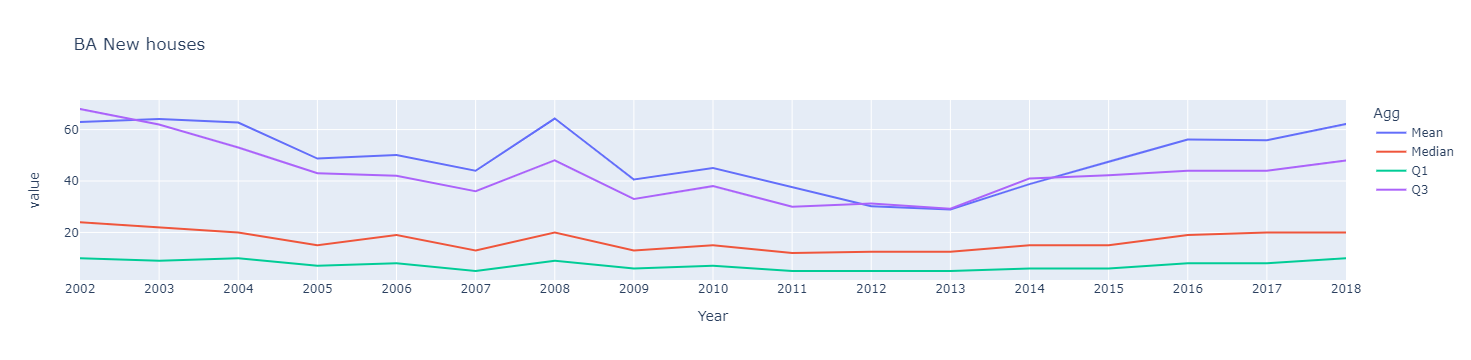

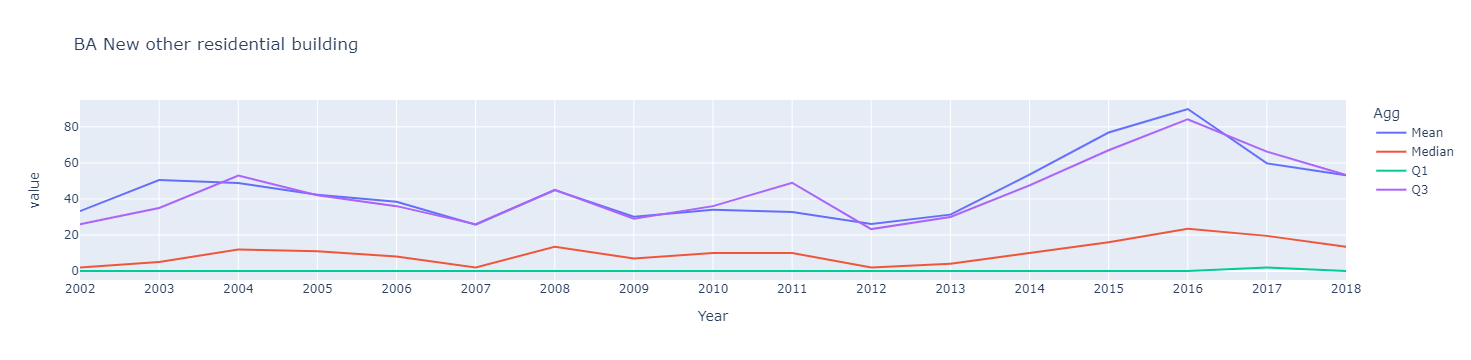

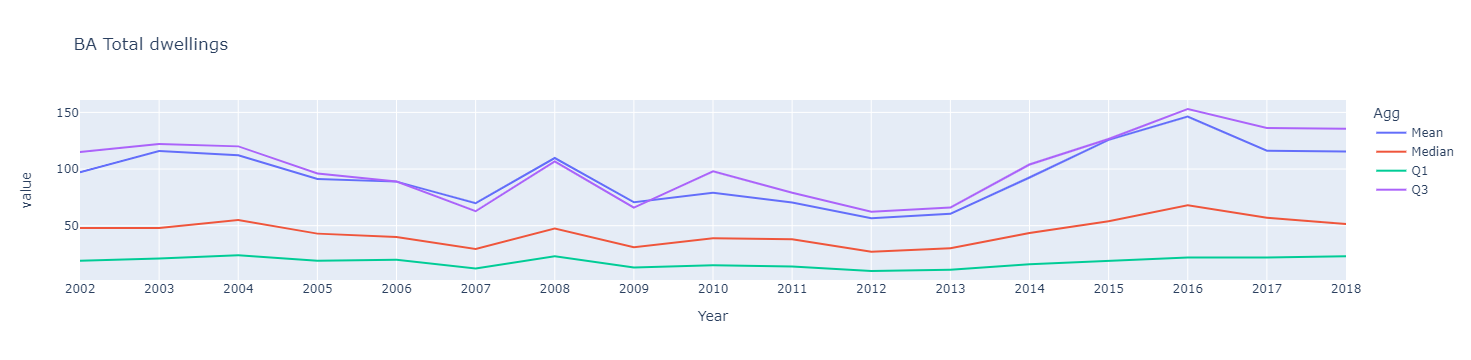

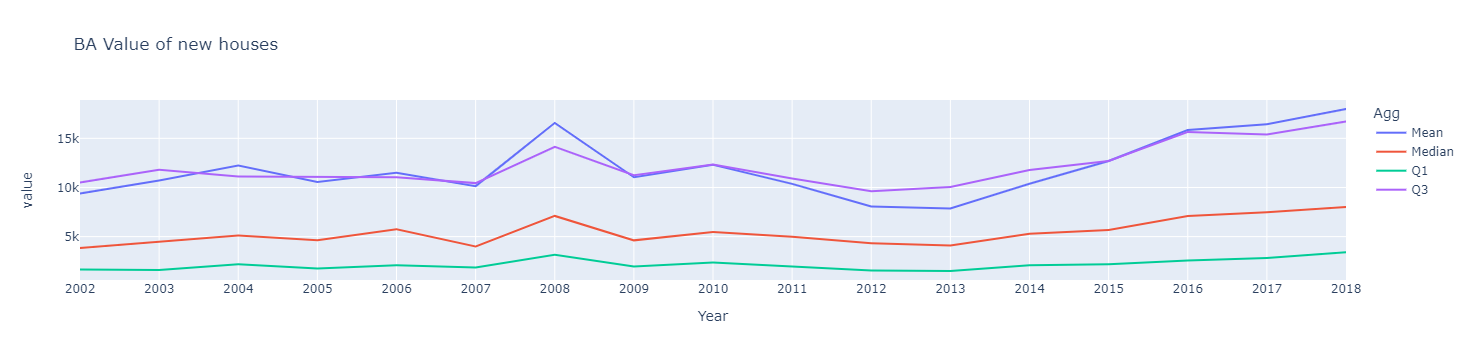

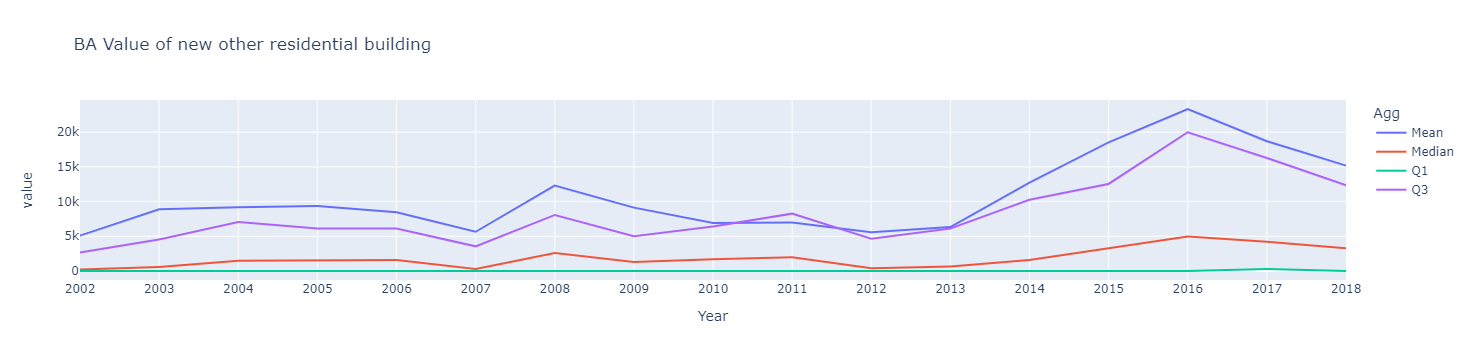

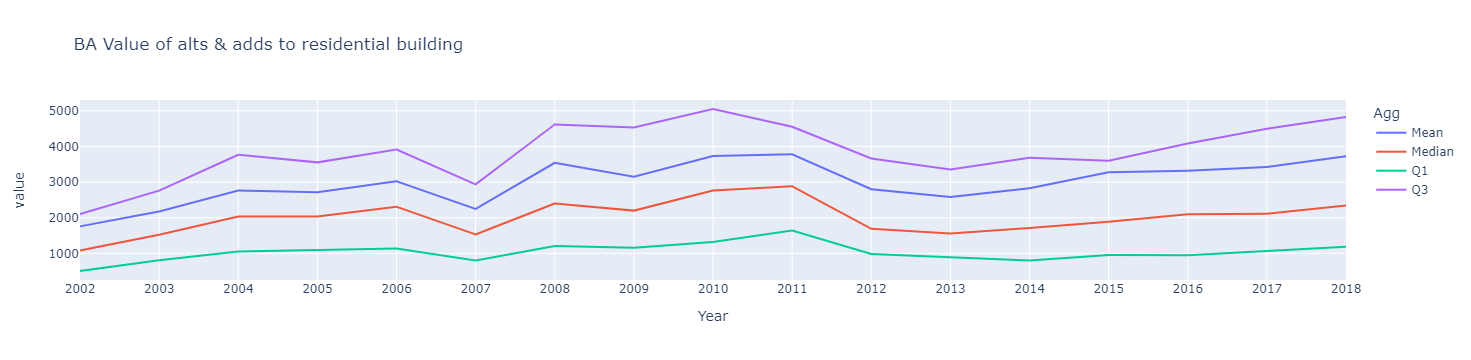

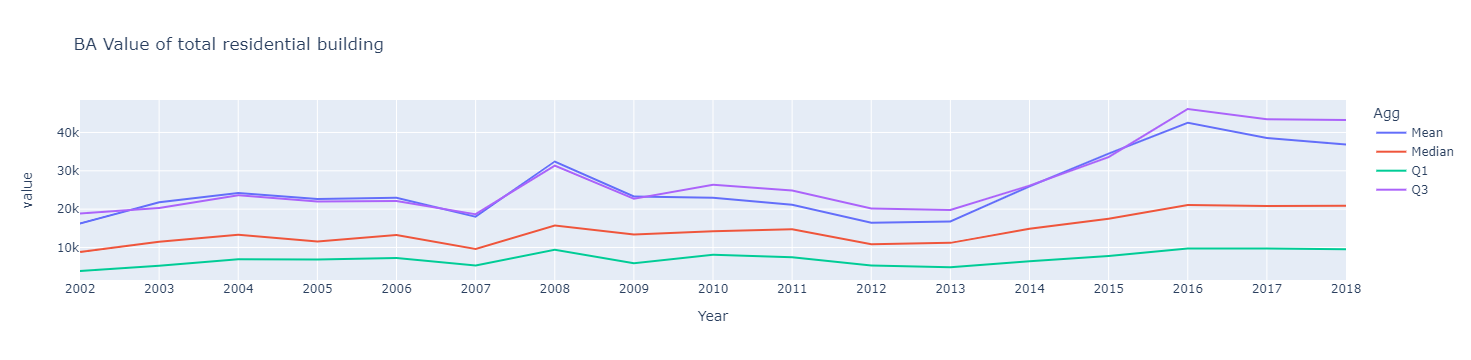

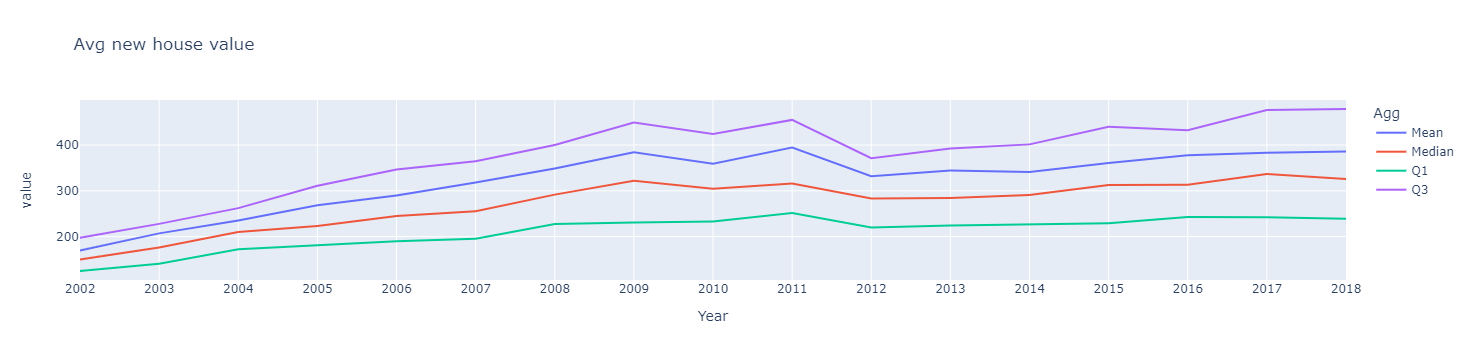

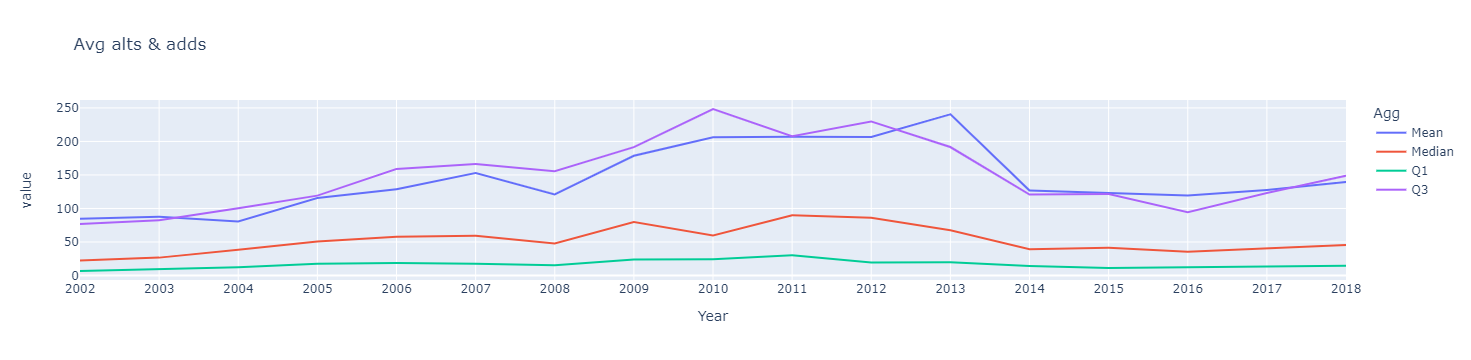

In [27]:
# Plot how Q1, median, Q3 and Mean has moved over time for Building Approvals
for col in df_time_agg.columns:
    if col not in ('Year', 'Agg'):
        chart = col
        df_plot = df_time_agg.pivot(index='Year', columns=agg_label)[col].reset_index()
        fig = px.line(df_plot, x="Year", y=df_plot.columns,
                      title=col)
        fig.update_xaxes(
            dtick="M1")
        fig.show()

### Now let's isolate Target variable and look for predictive factors

Let's isolate correlation to just the target variable, `'Small-scale solar panel system installations (no.) 2017'`, to see what correlates with it.

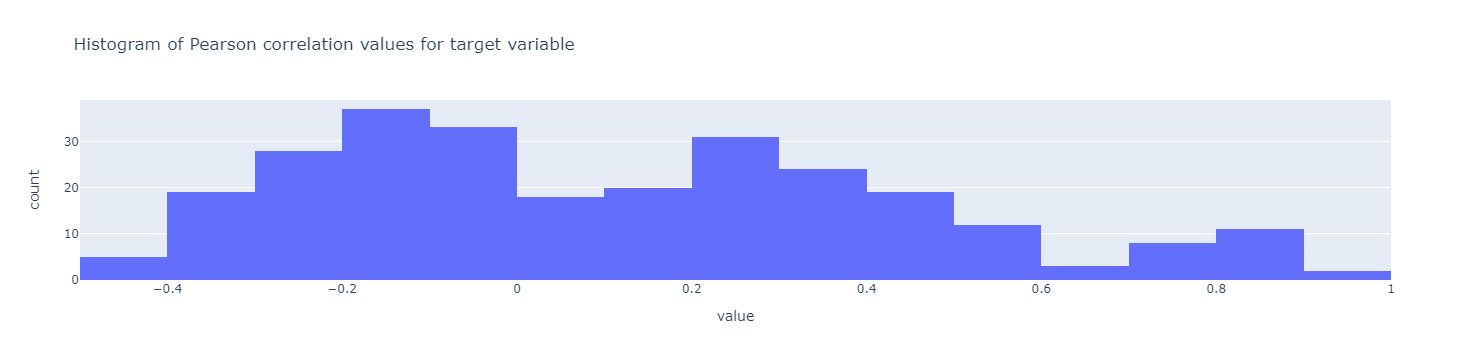

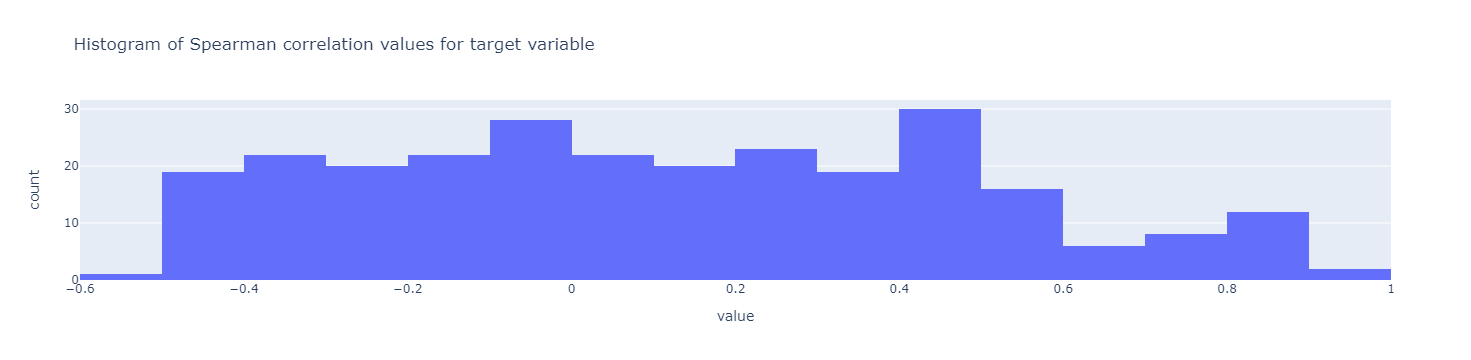

In [28]:
# Histogram of correlation values to determine what the correlation looks like
# This could be better as a density but I find it more informative as a count
fig = px.histogram(
    correlation_mat[target_col].loc[[col for col in correlation_mat.index if col != target_col]],
    title='Histogram of Pearson correlation values for target variable'
)

fig.update_layout(showlegend=False)
fig.show()

fig = px.histogram(
    spearman_mat[target_col].loc[[col for col in correlation_mat.index if col != target_col]],
    title='Histogram of Spearman correlation values for target variable',
)

fig.update_layout(showlegend=False)
fig.show()

There seems to be a cluster with Spearman/Pearson correlation above 0.6 which is a strong positive relationship and some below -0.5 which could indicate predictive power.

It would also be interesting to see which variables return very low correlation.

---

## Question 2

> Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.

Some notes:
* Solar panel installations ~ Solar water heaters - these probably do not indicate opportunities but are people deciding to install both at once


---

---

## Question 3

> Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.

---

---

## Question 4

> Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

---

Keep track of thoughts for later...

Some things that could be useful:

Financial data:
* Electricity prices over time
* Average wages by industry
* Distance to customer could be recorded as a 2d vector to enhance geometric understanding of this relationship

Demographic data:
* Election results
* Average building height?

Geographical data:
* Weather
* Altitude

Generally:
* More time points
* 

---